In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.cluster import MeanShift, estimate_bandwidth

from imblearn.over_sampling import SMOTE

import time
from datetime import datetime
import sqlite3 as sql

import warnings
warnings.filterwarnings("ignore")

In [71]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [72]:

data = pd.read_csv("../data/dataset.csv", delimiter=";")
df = data.copy()

In [73]:
df.shape

(99976, 43)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

In [75]:
df.replace("no_match", np.nan, inplace=True)
df["has_paid"].replace([True, False], [1,0], inplace=True)

# Histograms

---

---

---




-------
default
-------

Descriptive Statistics for default:
-----------------------------------

count    89976.000000
mean         0.014315
std          0.118786
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64




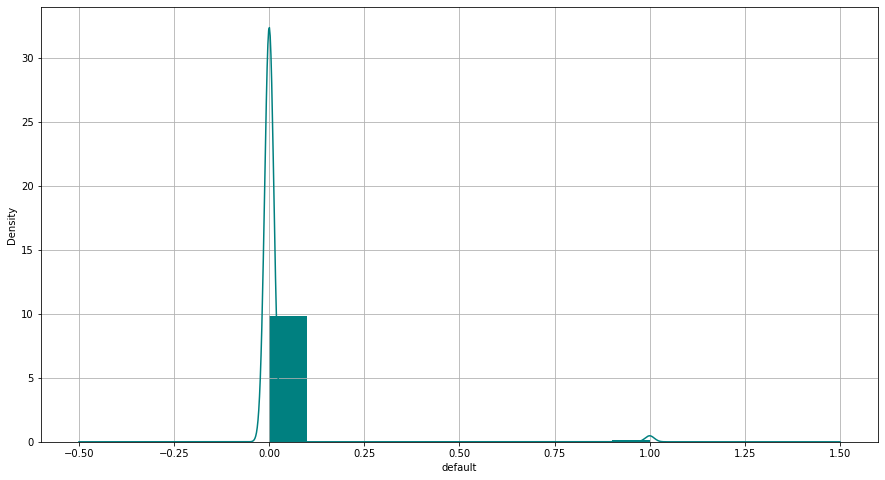




---------------------------
account_amount_added_12_24m
---------------------------

Descriptive Statistics for account_amount_added_12_24m:
-------------------------------------------------------

count    9.997600e+04
mean     1.225515e+04
std      3.548148e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.937250e+03
max      1.128775e+06
Name: account_amount_added_12_24m, dtype: float64




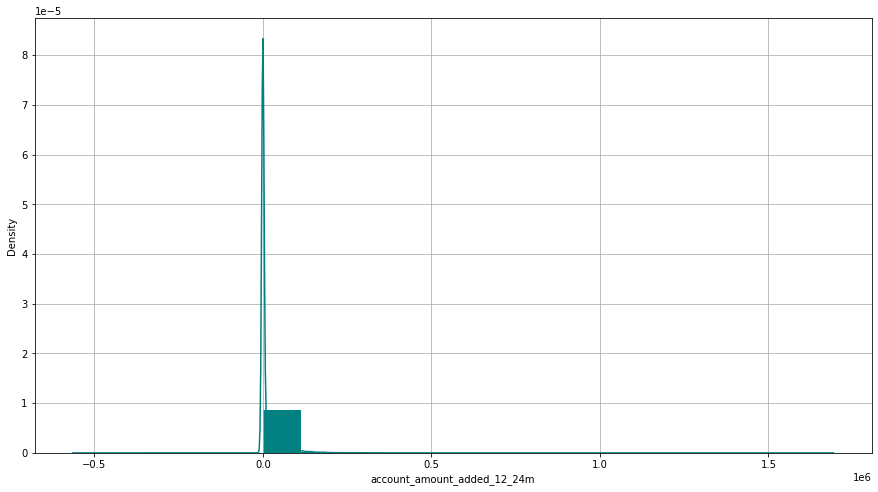




-------------------------
account_days_in_dc_12_24m
-------------------------

Descriptive Statistics for account_days_in_dc_12_24m:
-----------------------------------------------------

count    88140.000000
mean         0.223043
std          5.808117
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        365.000000
Name: account_days_in_dc_12_24m, dtype: float64




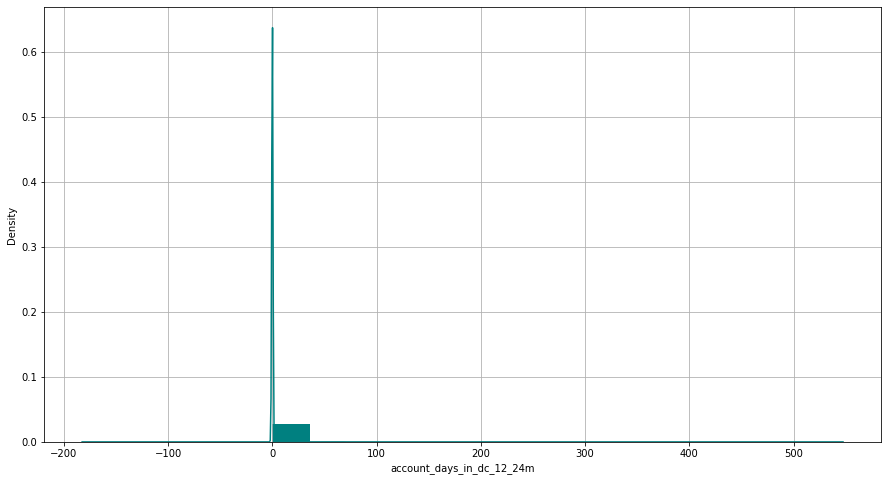




--------------------------
account_days_in_rem_12_24m
--------------------------

Descriptive Statistics for account_days_in_rem_12_24m:
------------------------------------------------------

count    88140.000000
mean         5.044622
std         22.863971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        365.000000
Name: account_days_in_rem_12_24m, dtype: float64




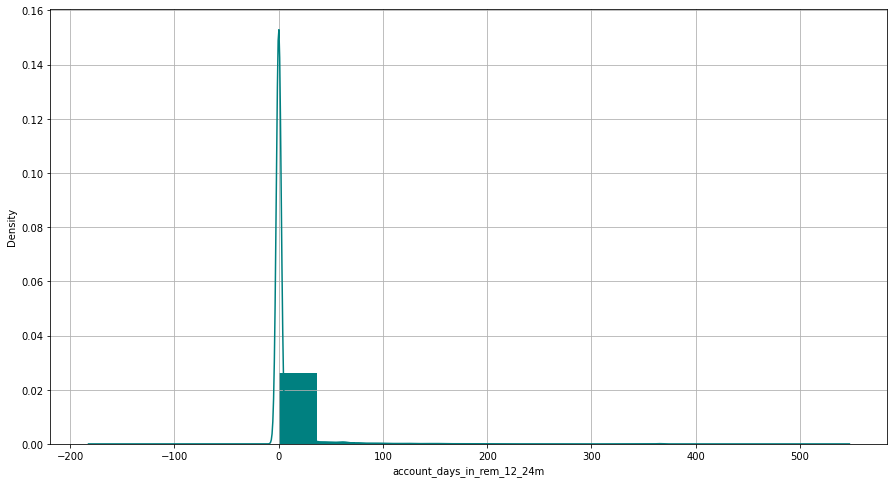




---------------------------
account_days_in_term_12_24m
---------------------------

Descriptive Statistics for account_days_in_term_12_24m:
-------------------------------------------------------

count    88140.000000
mean         0.286896
std          2.929910
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         97.000000
Name: account_days_in_term_12_24m, dtype: float64




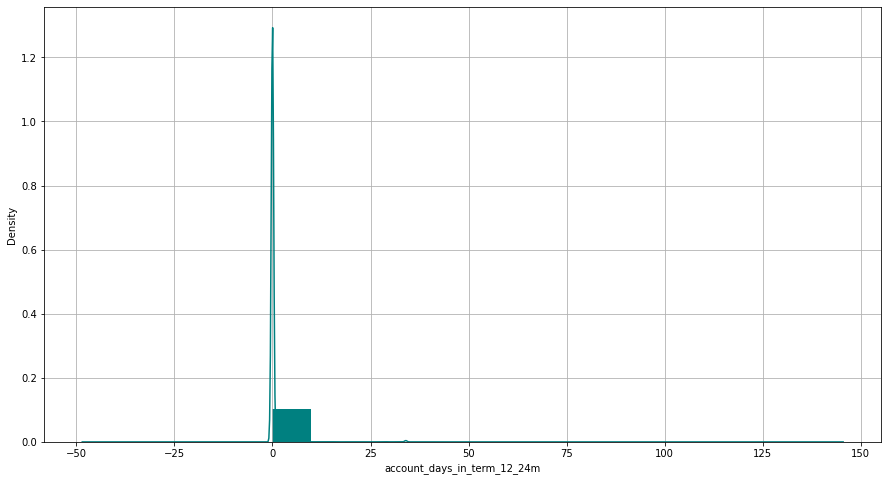




-----------------------------------
account_incoming_debt_vs_paid_0_24m
-----------------------------------

Descriptive Statistics for account_incoming_debt_vs_paid_0_24m:
---------------------------------------------------------------

count    40661.000000
mean         1.331292
std         26.482299
min          0.000000
25%          0.000000
50%          0.152082
75%          0.662952
max       3914.000000
Name: account_incoming_debt_vs_paid_0_24m, dtype: float64




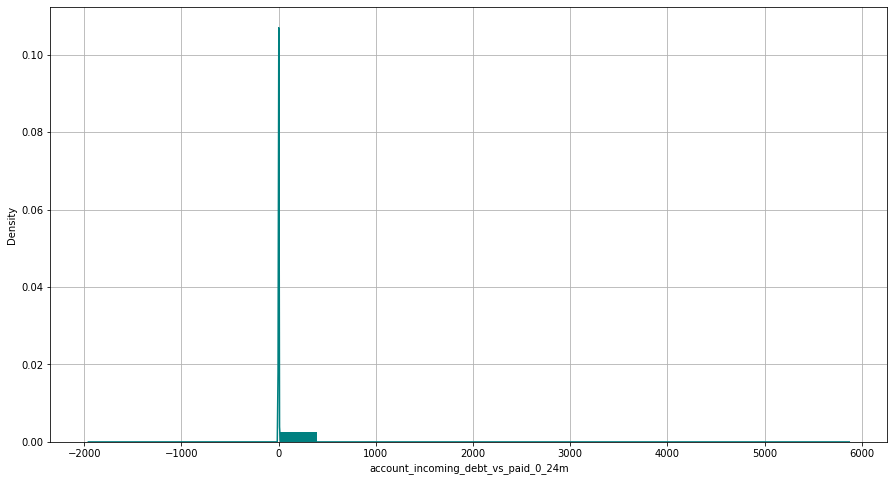




--------------
account_status
--------------

Descriptive Statistics for account_status:
------------------------------------------

count    45603.000000
mean         1.042168
std          0.202713
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: account_status, dtype: float64




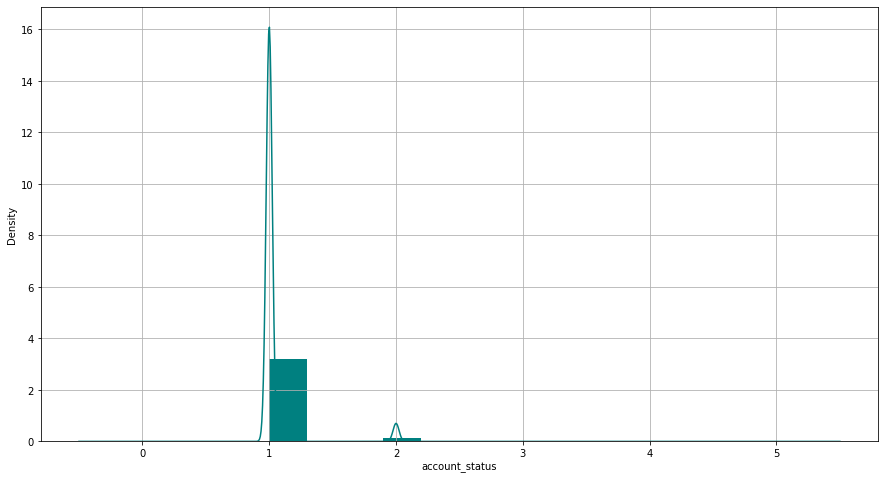




-------------------------
account_worst_status_0_3m
-------------------------

Descriptive Statistics for account_worst_status_0_3m:
-----------------------------------------------------

count    45603.000000
mean         1.172905
std          0.420142
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: account_worst_status_0_3m, dtype: float64




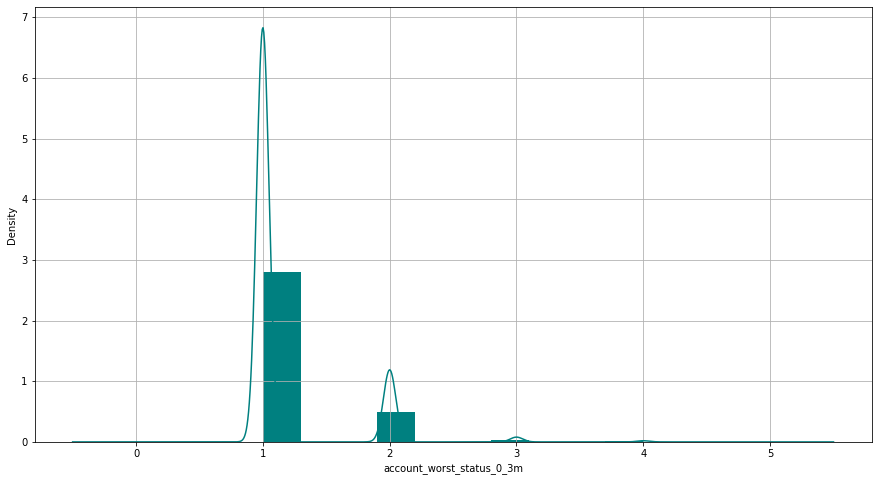




---------------------------
account_worst_status_12_24m
---------------------------

Descriptive Statistics for account_worst_status_12_24m:
-------------------------------------------------------

count    33215.000000
mean         1.337348
std          0.575043
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: account_worst_status_12_24m, dtype: float64




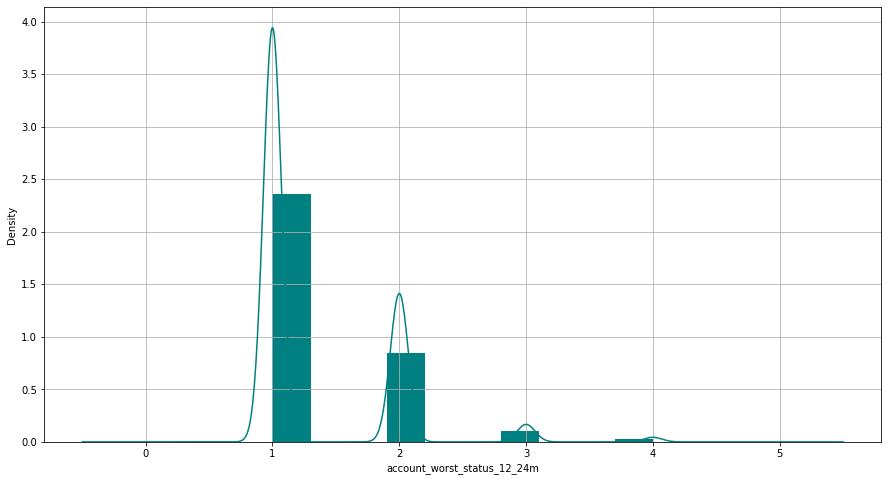




-------------------------
account_worst_status_3_6m
-------------------------

Descriptive Statistics for account_worst_status_3_6m:
-----------------------------------------------------

count    42274.000000
mean         1.185291
std          0.443309
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: account_worst_status_3_6m, dtype: float64




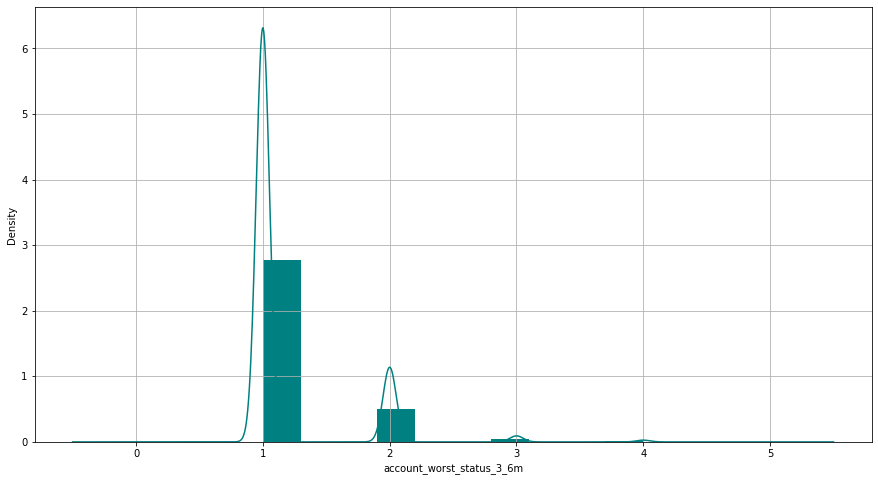




--------------------------
account_worst_status_6_12m
--------------------------

Descriptive Statistics for account_worst_status_6_12m:
------------------------------------------------------

count    39626.000000
mean         1.253142
std          0.505559
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: account_worst_status_6_12m, dtype: float64




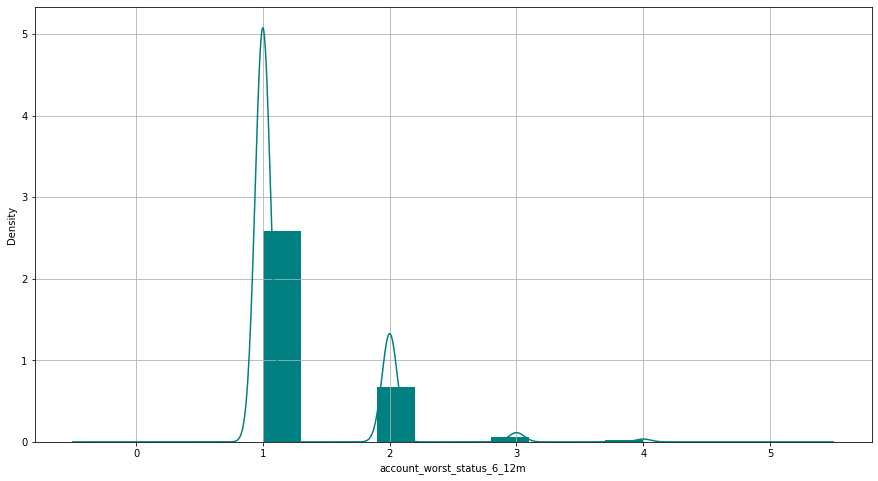




---
age
---

Descriptive Statistics for age:
-------------------------------

count    99976.000000
mean        36.016284
std         13.001306
min         18.000000
25%         25.000000
50%         34.000000
75%         45.000000
max        100.000000
Name: age, dtype: float64




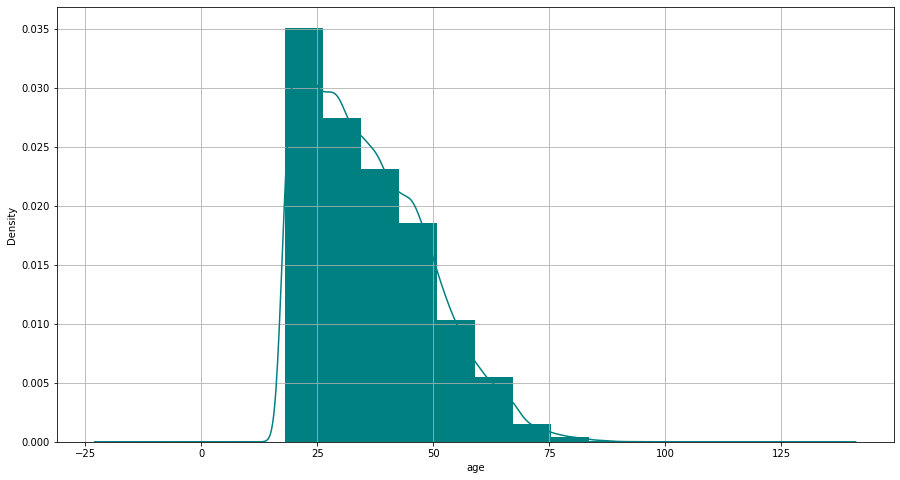




----------------------
avg_payment_span_0_12m
----------------------

Descriptive Statistics for avg_payment_span_0_12m:
--------------------------------------------------

count    76140.000000
mean        17.971473
std         12.751066
min          0.000000
25%         10.800000
50%         14.909091
75%         21.000000
max        260.000000
Name: avg_payment_span_0_12m, dtype: float64




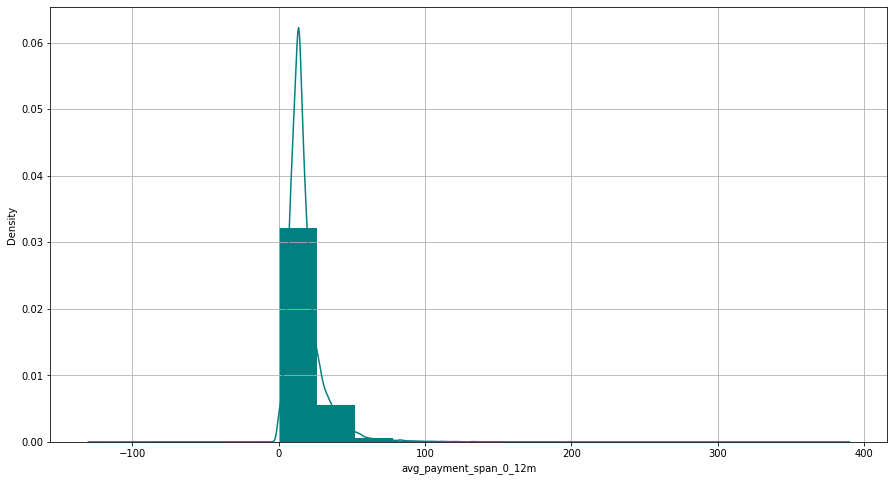




---------------------
avg_payment_span_0_3m
---------------------

Descriptive Statistics for avg_payment_span_0_3m:
-------------------------------------------------

count    50671.000000
mean        14.989786
std         10.297420
min          0.000000
25%          8.400000
50%         13.000000
75%         18.285714
max         87.000000
Name: avg_payment_span_0_3m, dtype: float64




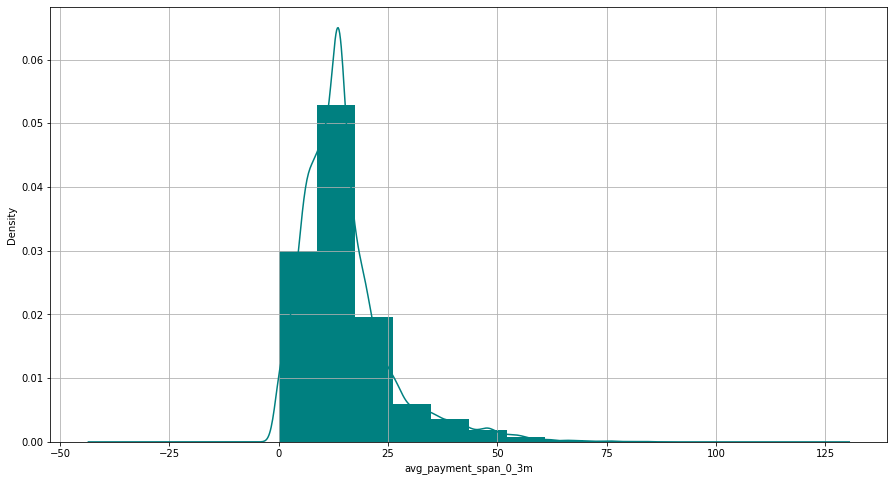




--------
has_paid
--------

Descriptive Statistics for has_paid:
------------------------------------

count    99976.000000
mean         0.851164
std          0.355928
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: has_paid, dtype: float64




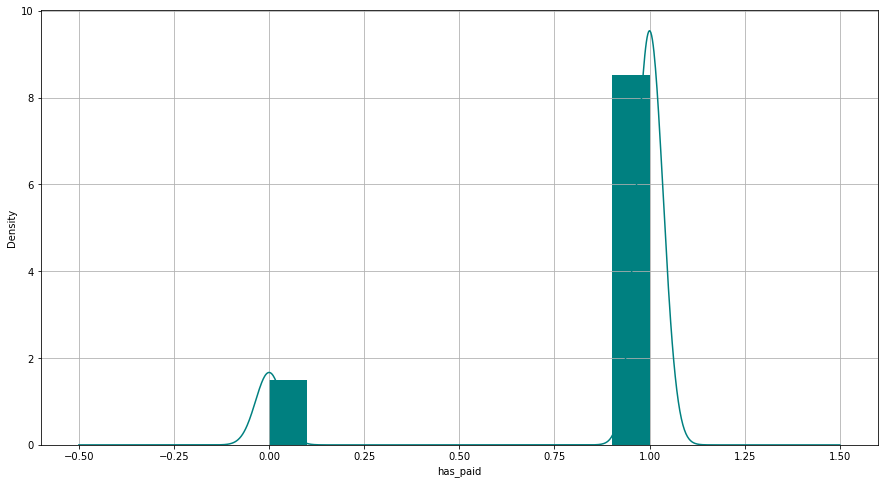




------------------
max_paid_inv_0_12m
------------------

Descriptive Statistics for max_paid_inv_0_12m:
----------------------------------------------

count     99976.000000
mean       9203.654217
std       13512.167229
min           0.000000
25%        2000.000000
50%        6052.000000
75%       11380.000000
max      279000.000000
Name: max_paid_inv_0_12m, dtype: float64




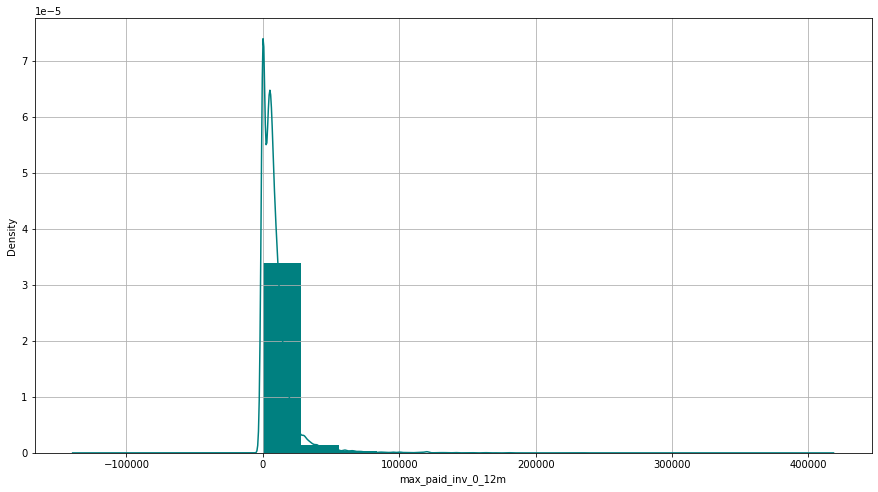




------------------
max_paid_inv_0_24m
------------------

Descriptive Statistics for max_paid_inv_0_24m:
----------------------------------------------

count     99976.000000
mean      11215.120819
std       15256.414937
min           0.000000
25%        3350.000000
50%        7580.000000
75%       13783.000000
max      538500.000000
Name: max_paid_inv_0_24m, dtype: float64




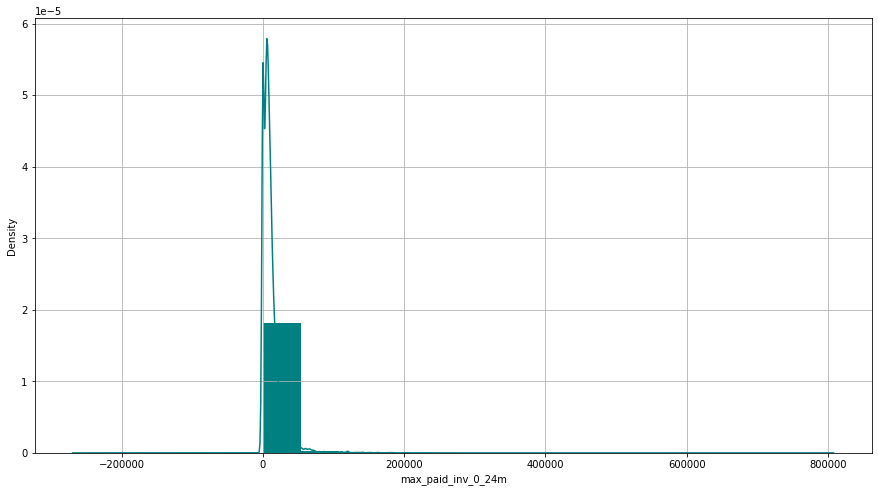




--------------------------------
num_active_div_by_paid_inv_0_12m
--------------------------------

Descriptive Statistics for num_active_div_by_paid_inv_0_12m:
------------------------------------------------------------

count    77037.000000
mean         0.114840
std          0.293483
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max          9.000000
Name: num_active_div_by_paid_inv_0_12m, dtype: float64




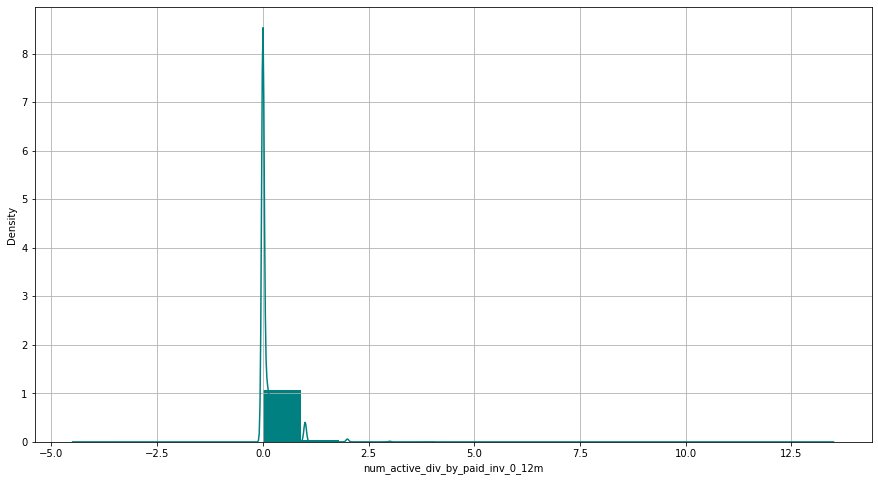




--------------
num_active_inv
--------------

Descriptive Statistics for num_active_inv:
------------------------------------------

count    99976.000000
mean         0.599404
std          1.550026
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         47.000000
Name: num_active_inv, dtype: float64




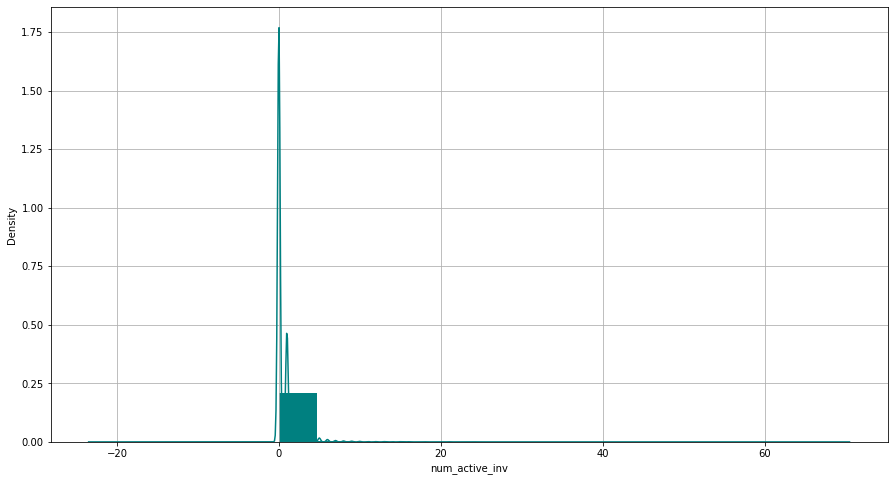




-----------------
num_arch_dc_0_12m
-----------------

Descriptive Statistics for num_arch_dc_0_12m:
---------------------------------------------

count    99976.000000
mean         0.061745
std          0.374691
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: num_arch_dc_0_12m, dtype: float64




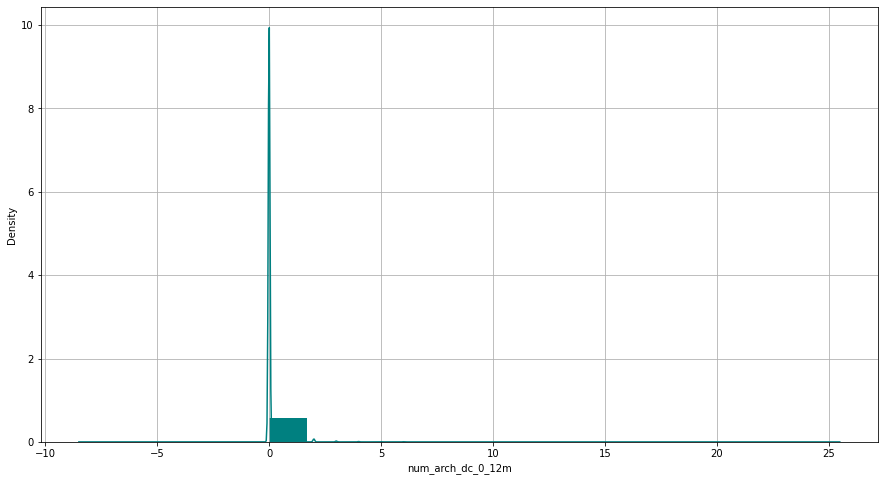




------------------
num_arch_dc_12_24m
------------------

Descriptive Statistics for num_arch_dc_12_24m:
----------------------------------------------

count    99976.000000
mean         0.059364
std          0.366224
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: num_arch_dc_12_24m, dtype: float64




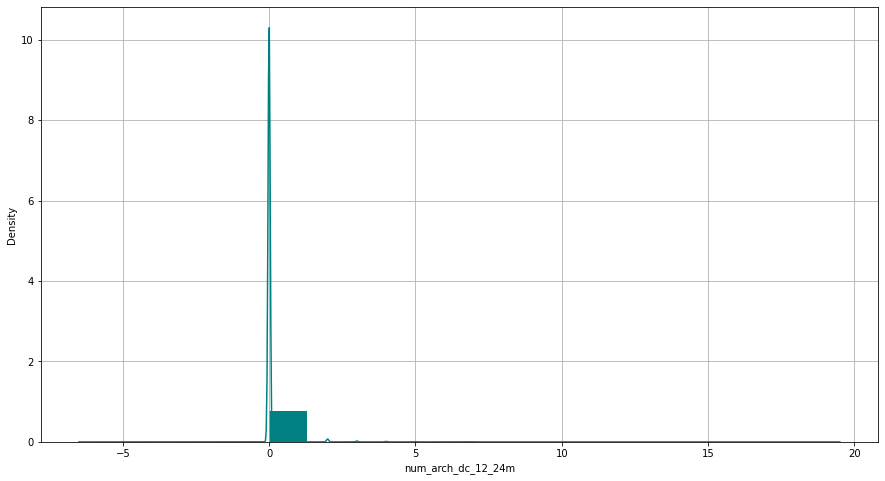




-----------------
num_arch_ok_0_12m
-----------------

Descriptive Statistics for num_arch_ok_0_12m:
---------------------------------------------

count    99976.000000
mean         7.275826
std         16.030369
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max        261.000000
Name: num_arch_ok_0_12m, dtype: float64




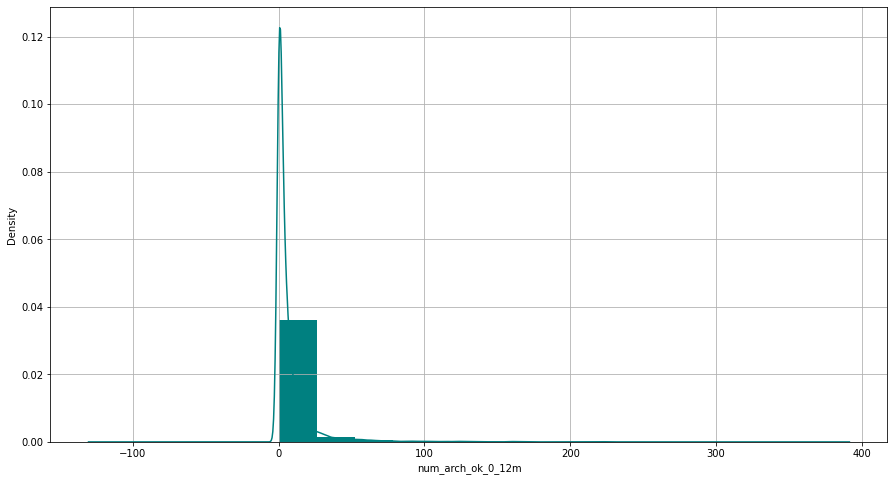




------------------
num_arch_ok_12_24m
------------------

Descriptive Statistics for num_arch_ok_12_24m:
----------------------------------------------

count    99976.000000
mean         6.369799
std         15.350244
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max        313.000000
Name: num_arch_ok_12_24m, dtype: float64




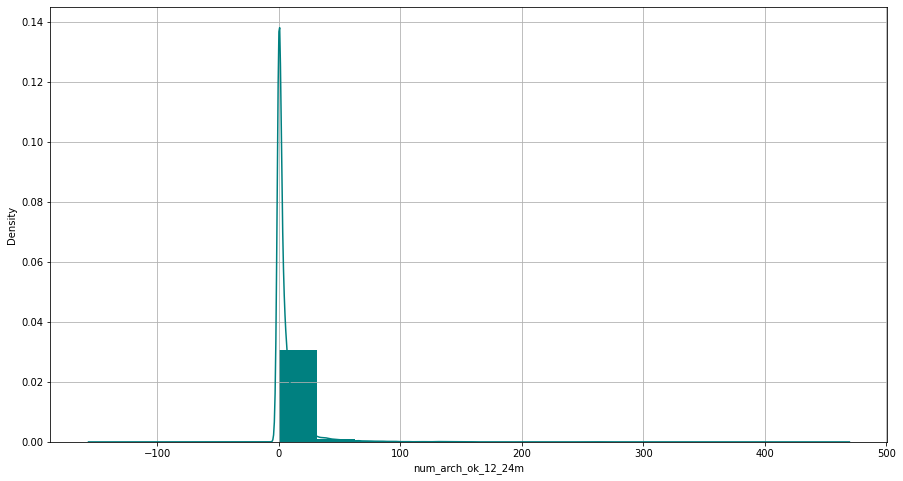




------------------
num_arch_rem_0_12m
------------------

Descriptive Statistics for num_arch_rem_0_12m:
----------------------------------------------

count    99976.000000
mean         0.469443
std          1.360349
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: num_arch_rem_0_12m, dtype: float64




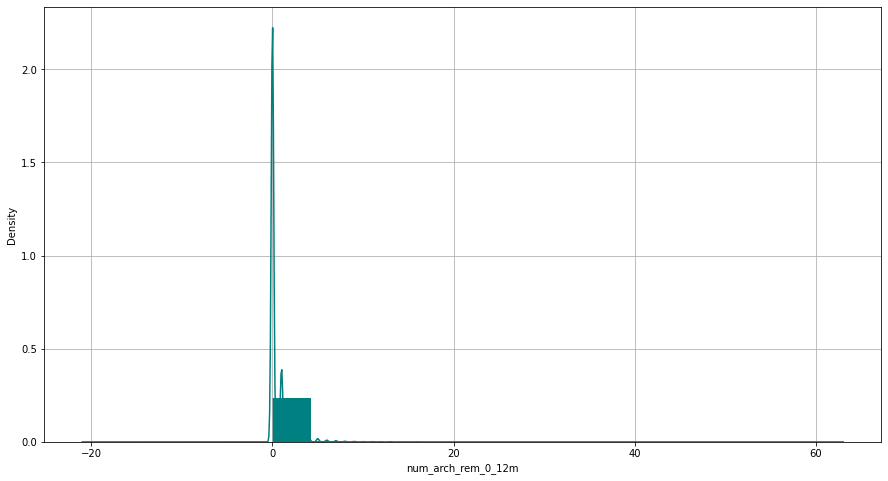




--------------------------
num_arch_written_off_0_12m
--------------------------

Descriptive Statistics for num_arch_written_off_0_12m:
------------------------------------------------------

count    81898.000000
mean         0.000122
std          0.011049
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: num_arch_written_off_0_12m, dtype: float64




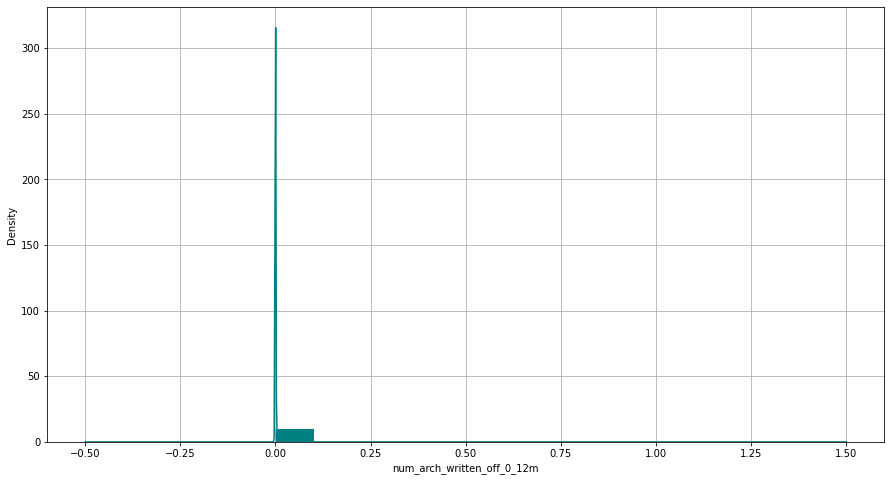




---------------------------
num_arch_written_off_12_24m
---------------------------

Descriptive Statistics for num_arch_written_off_12_24m:
-------------------------------------------------------

count    81898.000000
mean         0.000159
std          0.014407
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: num_arch_written_off_12_24m, dtype: float64




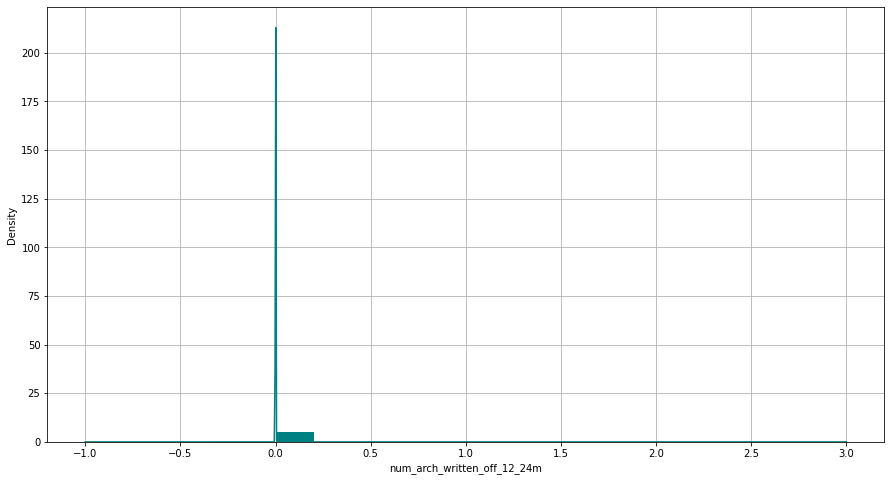




----------------
num_unpaid_bills
----------------

Descriptive Statistics for num_unpaid_bills:
--------------------------------------------

count    99976.000000
mean         2.141564
std          6.300978
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        182.000000
Name: num_unpaid_bills, dtype: float64




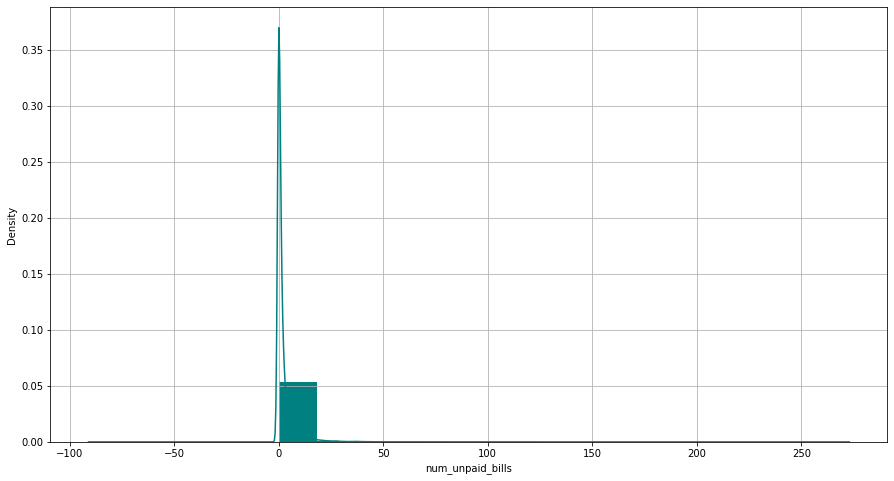




--------------------------
status_last_archived_0_24m
--------------------------

Descriptive Statistics for status_last_archived_0_24m:
------------------------------------------------------

count    99976.000000
mean         0.923202
std          0.569530
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: status_last_archived_0_24m, dtype: float64




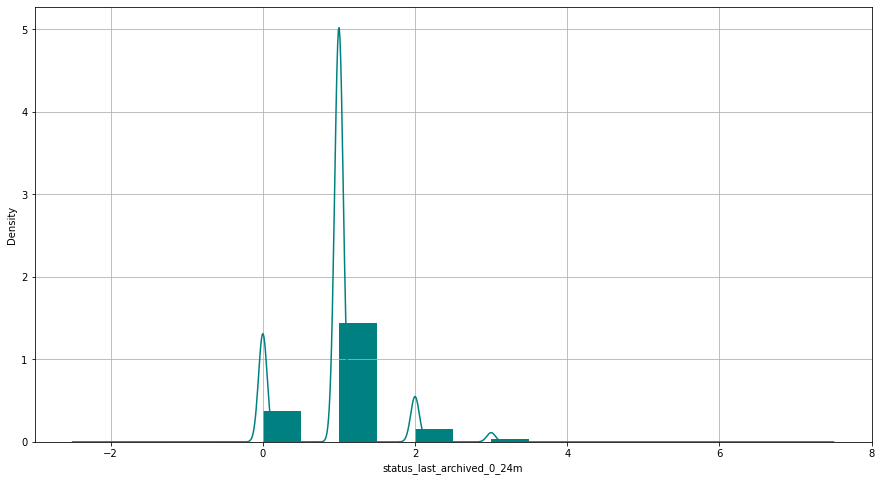




------------------------------
status_2nd_last_archived_0_24m
------------------------------

Descriptive Statistics for status_2nd_last_archived_0_24m:
----------------------------------------------------------

count    99976.000000
mean         0.827519
std          0.622812
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: status_2nd_last_archived_0_24m, dtype: float64




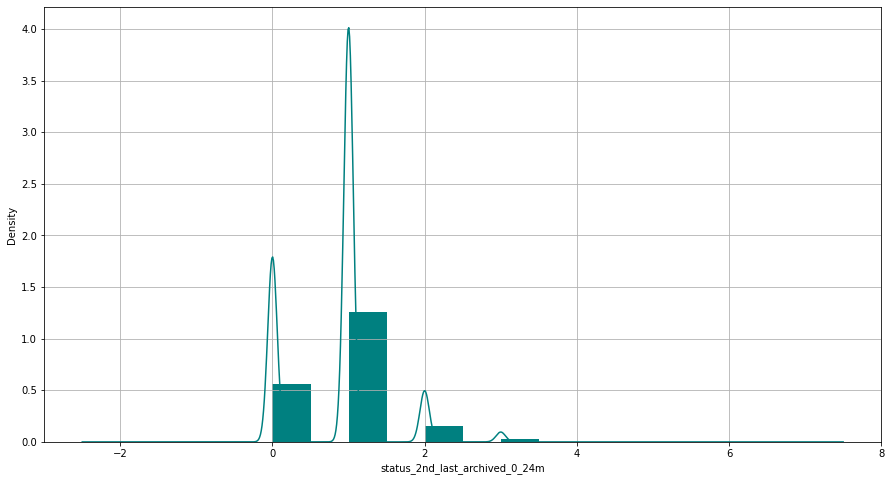




------------------------------
status_3rd_last_archived_0_24m
------------------------------

Descriptive Statistics for status_3rd_last_archived_0_24m:
----------------------------------------------------------

count    99976.000000
mean         0.744299
std          0.634912
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: status_3rd_last_archived_0_24m, dtype: float64




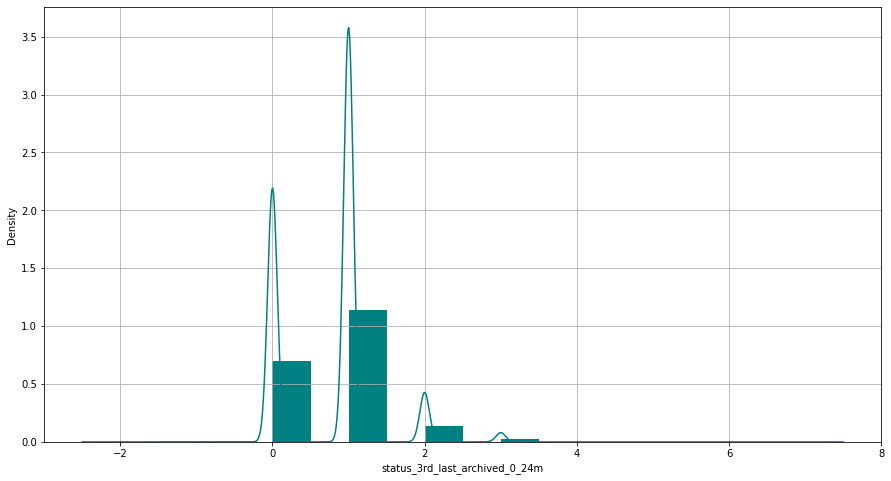




------------------------------
status_max_archived_0_6_months
------------------------------

Descriptive Statistics for status_max_archived_0_6_months:
----------------------------------------------------------

count    99976.000000
mean         0.800582
std          0.719946
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: status_max_archived_0_6_months, dtype: float64




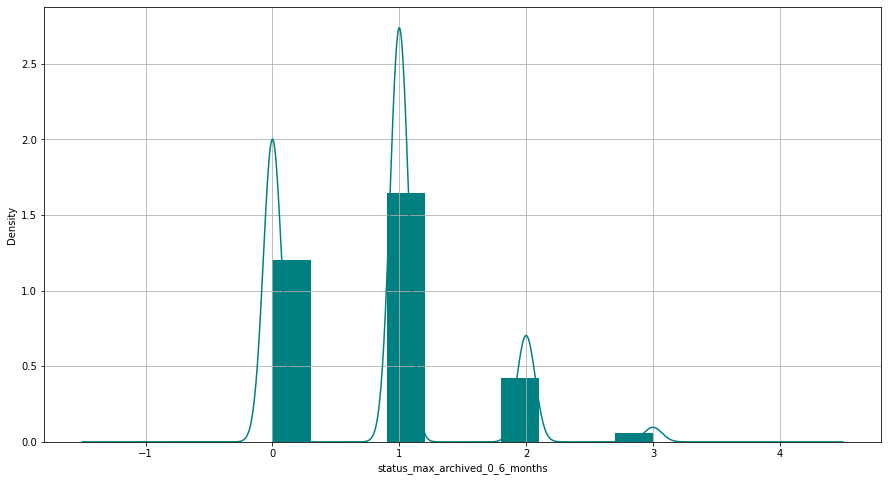




-------------------------------
status_max_archived_0_12_months
-------------------------------

Descriptive Statistics for status_max_archived_0_12_months:
-----------------------------------------------------------

count    99976.000000
mean         1.052233
std          0.786121
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: status_max_archived_0_12_months, dtype: float64




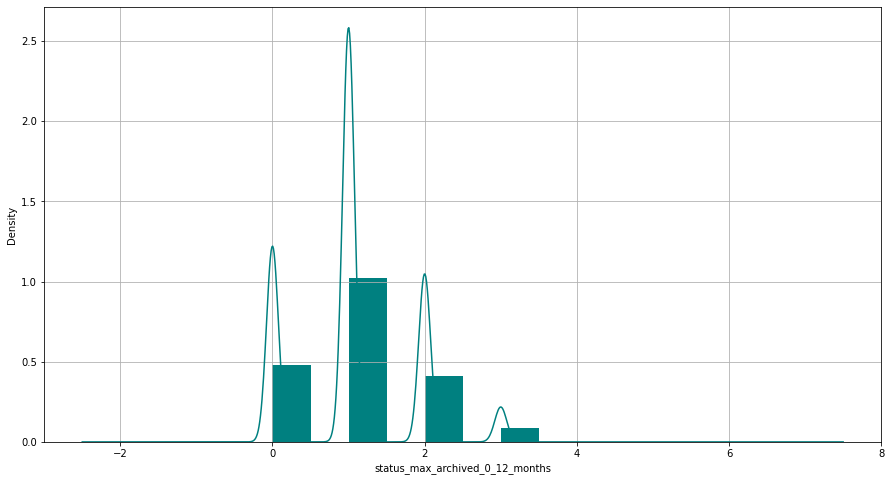




-------------------------------
status_max_archived_0_24_months
-------------------------------

Descriptive Statistics for status_max_archived_0_24_months:
-----------------------------------------------------------

count    99976.000000
mean         1.226164
std          0.833502
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: status_max_archived_0_24_months, dtype: float64




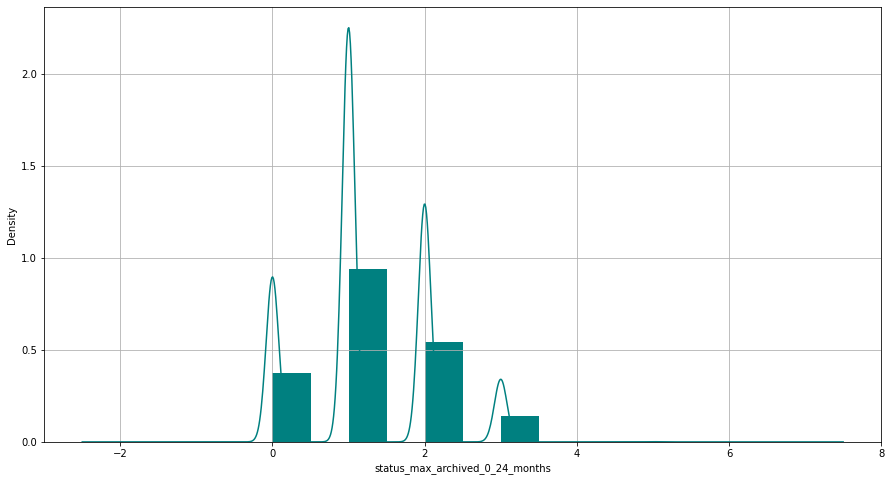




-------------
recovery_debt
-------------

Descriptive Statistics for recovery_debt:
-----------------------------------------

count    99976.000000
mean         4.035429
std        163.934564
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      36479.000000
Name: recovery_debt, dtype: float64




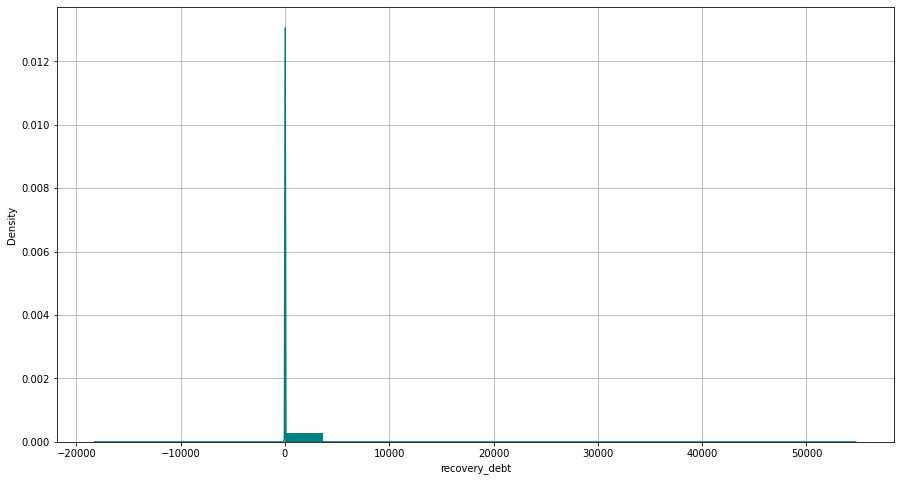




------------------------------
sum_capital_paid_account_0_12m
------------------------------

Descriptive Statistics for sum_capital_paid_account_0_12m:
----------------------------------------------------------

count     99976.000000
mean      10816.065386
std       26463.972170
min           0.000000
25%           0.000000
50%           0.000000
75%        9029.750000
max      571475.000000
Name: sum_capital_paid_account_0_12m, dtype: float64




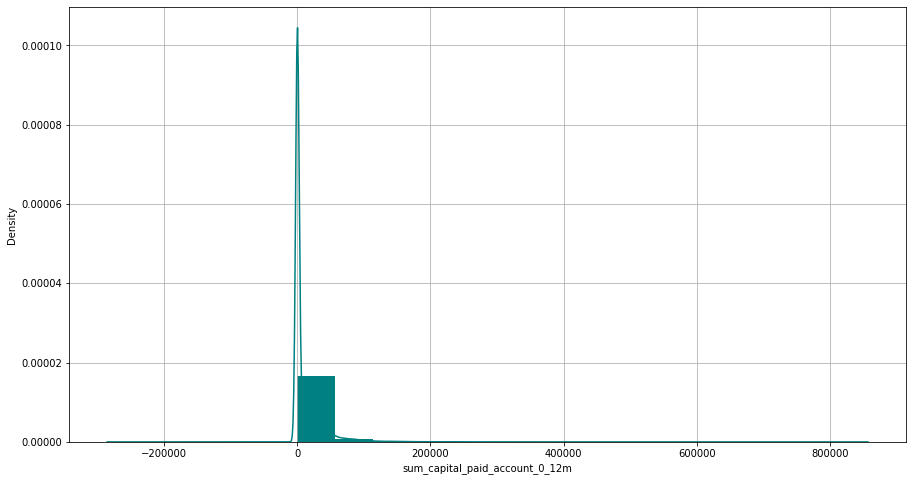




-------------------------------
sum_capital_paid_account_12_24m
-------------------------------

Descriptive Statistics for sum_capital_paid_account_12_24m:
-----------------------------------------------------------

count     99976.000000
mean       6542.895325
std       19041.223585
min           0.000000
25%           0.000000
50%           0.000000
75%          85.000000
max      341859.000000
Name: sum_capital_paid_account_12_24m, dtype: float64




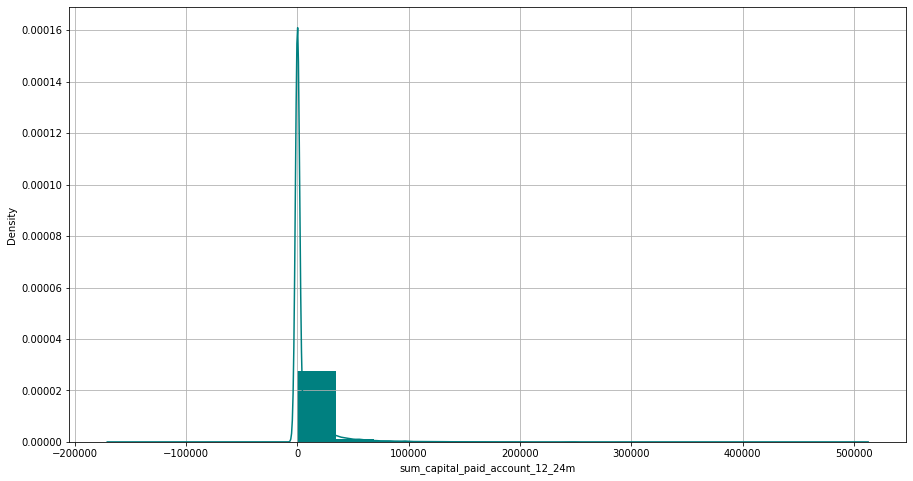




------------------
sum_paid_inv_0_12m
------------------

Descriptive Statistics for sum_paid_inv_0_12m:
----------------------------------------------

count    9.997600e+04
mean     3.920880e+04
std      9.064929e+04
min      0.000000e+00
25%      2.600000e+03
50%      1.599500e+04
75%      4.384425e+04
max      2.962870e+06
Name: sum_paid_inv_0_12m, dtype: float64




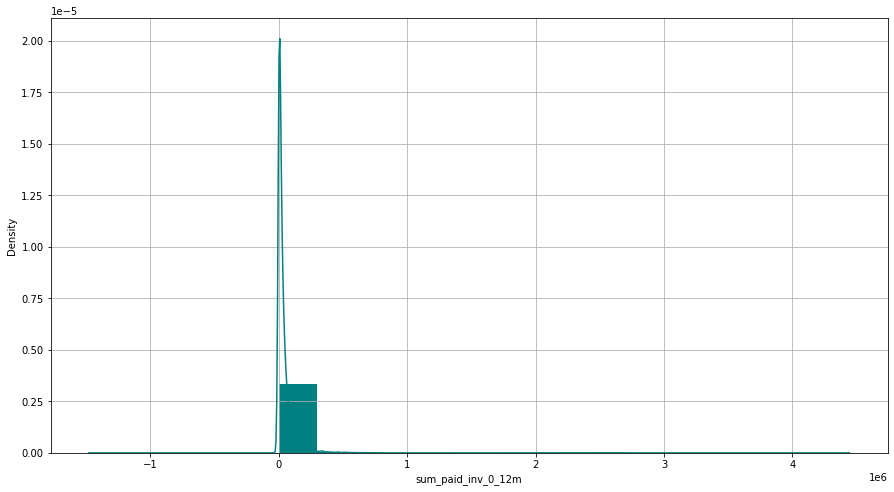




----------
time_hours
----------

Descriptive Statistics for time_hours:
--------------------------------------

count    99976.000000
mean        15.329780
std          5.031360
min          0.000278
25%         11.622708
50%         15.792778
75%         19.542014
max         23.999722
Name: time_hours, dtype: float64




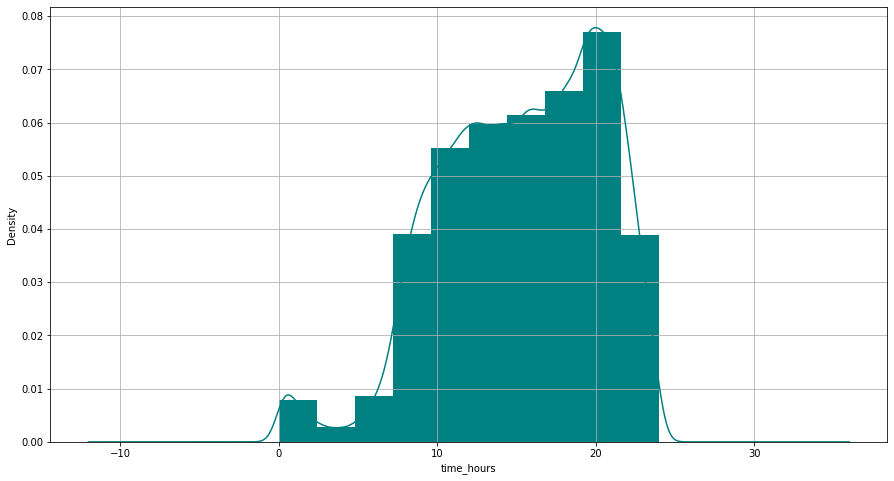




-----------------------
worst_status_active_inv
-----------------------

Descriptive Statistics for worst_status_active_inv:
---------------------------------------------------

count    30461.000000
mean         1.121762
std          0.343660
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: worst_status_active_inv, dtype: float64




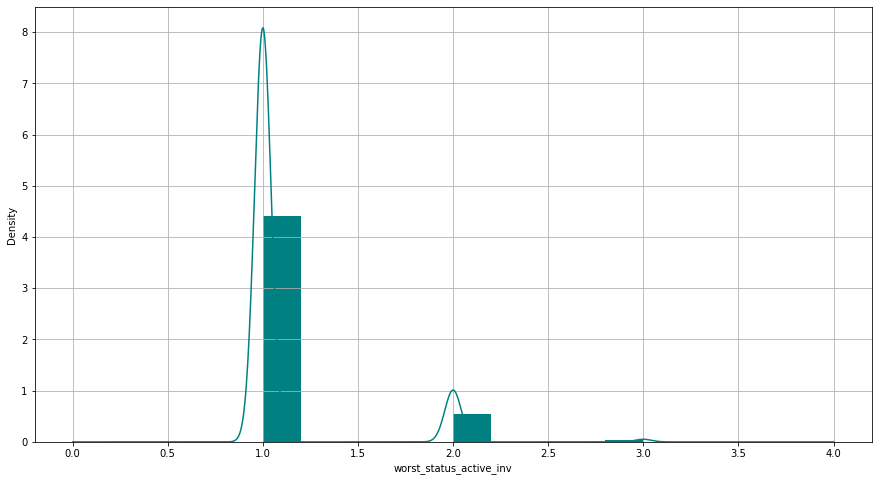

In [76]:

for col in df.select_dtypes(exclude="object").columns.to_list():
    plt.figure(figsize=(15,8))
    ax = df[col].hist(density=True, stacked=True, color='teal')
    df[col].plot(kind='density', color='teal')
    ax.set(xlabel=col)
    print("\n\n")
    print("-"*len(col))
    print(col)
    print("-"*len(col))
    print("")
    print(f"Descriptive Statistics for {col}:")
    print("-"*(len(col) + 28))
    print("")
    print(df[col].describe())
    print("\n")
    plt.grid()
    plt.show()


---

---

---

# Bar Plots

---

---

---

-----------------
num_arch_dc_0_12m
-----------------

Unique values of 'num_arch_dc_0_12m':
-------------------------------------
0     95724
1      3192
2       681
3       196
4        77
6        35
5        30
7        21
8         5
10        4
13        4
11        3
9         2
16        1
17        1
Name: num_arch_dc_0_12m, dtype: int64




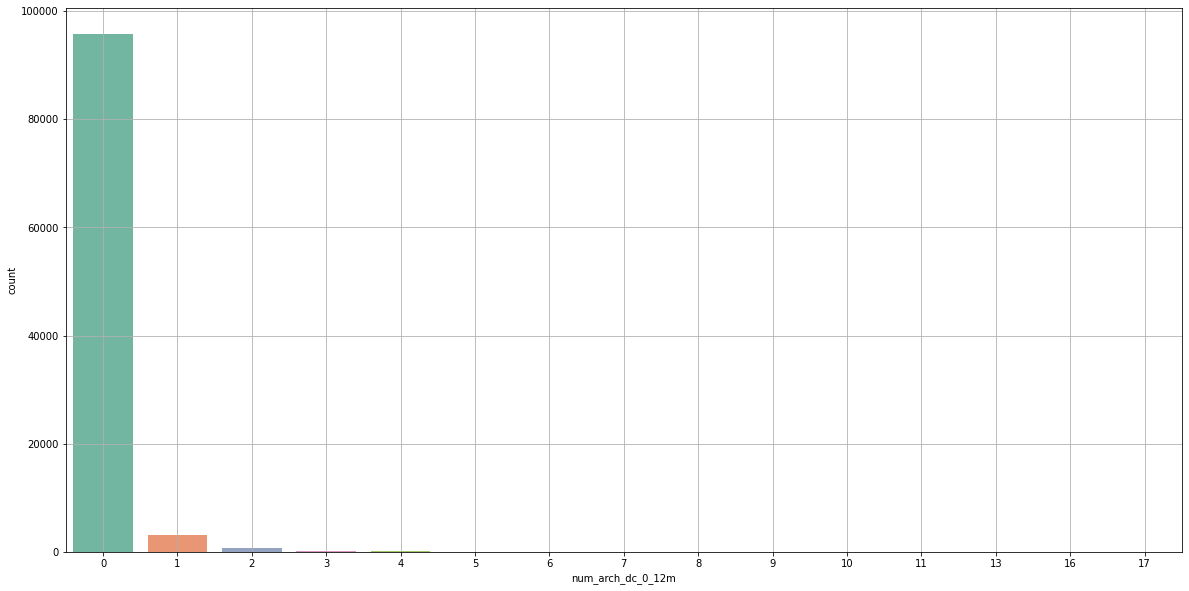

------------------
num_arch_dc_12_24m
------------------

Unique values of 'num_arch_dc_12_24m':
--------------------------------------
0     95991
1      2913
2       665
3       195
4       106
5        46
7        24
6        17
8         6
10        6
11        4
9         2
13        1
Name: num_arch_dc_12_24m, dtype: int64




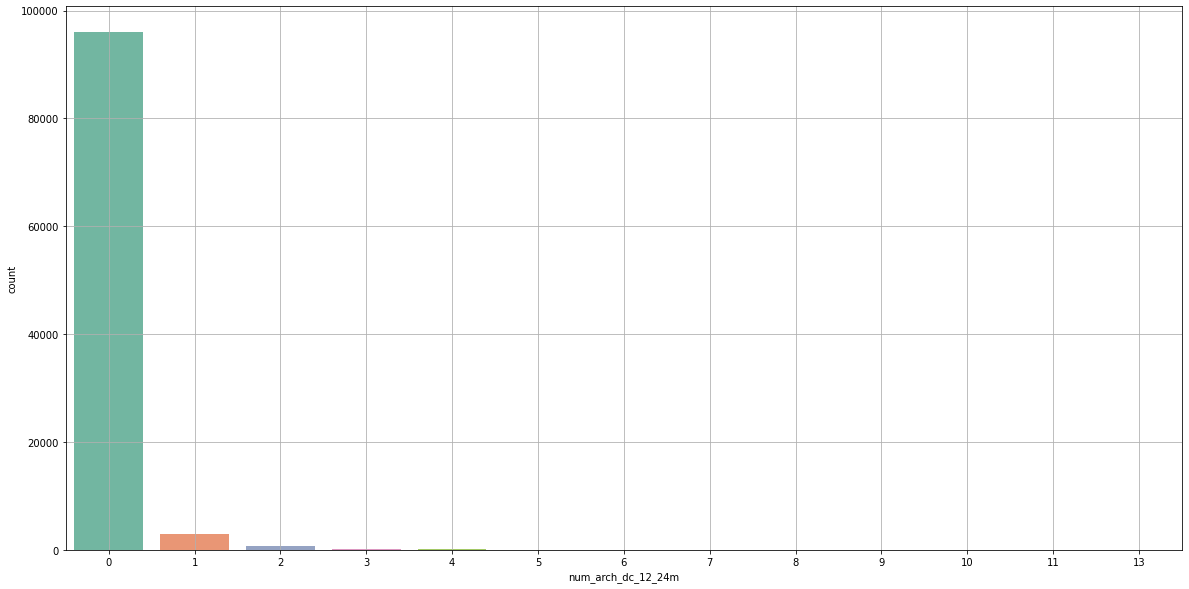

--------------
merchant_group
--------------

Unique values of 'merchant_group':
----------------------------------
Entertainment             48779
Clothing & Shoes          16728
Leisure, Sport & Hobby    11025
Health & Beauty            7356
Children Products          5108
Home & Garden              3718
Electronics                3034
Intangible products        1122
Jewelry & Accessories      1058
Automotive Products         937
Erotic Materials            747
Food & Beverage             364
Name: merchant_group, dtype: int64




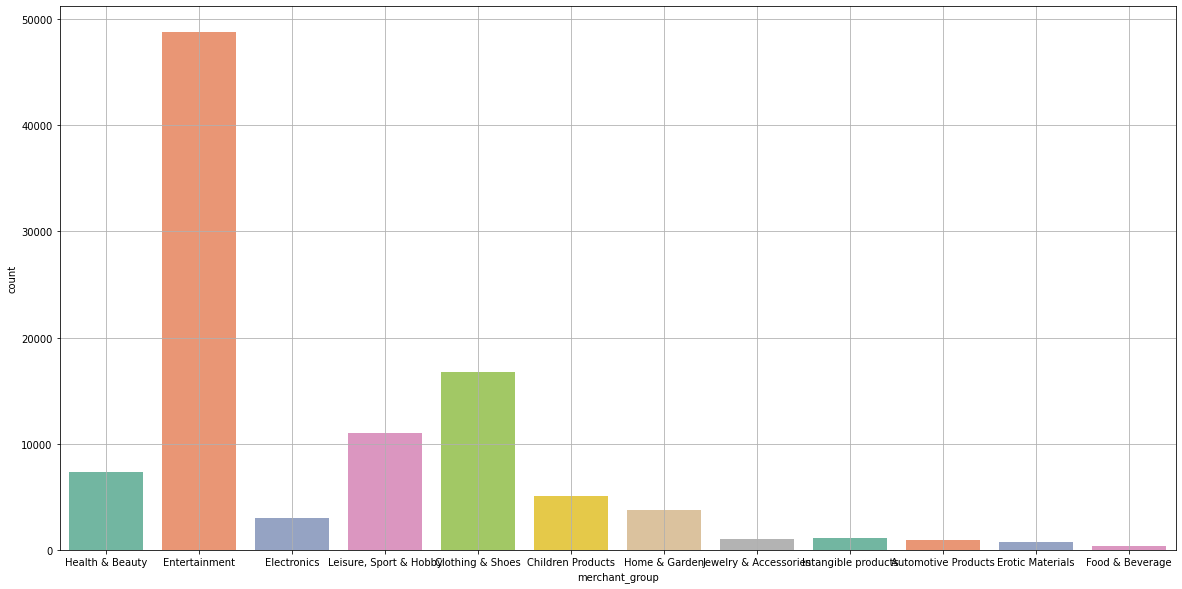

-------------
name_in_email
-------------

Unique values of 'name_in_email':
---------------------------------
F+L         40389
L1+F        16089
F            9705
Nick         8310
F1+L         7300
L            1332
Initials       25
Name: name_in_email, dtype: int64




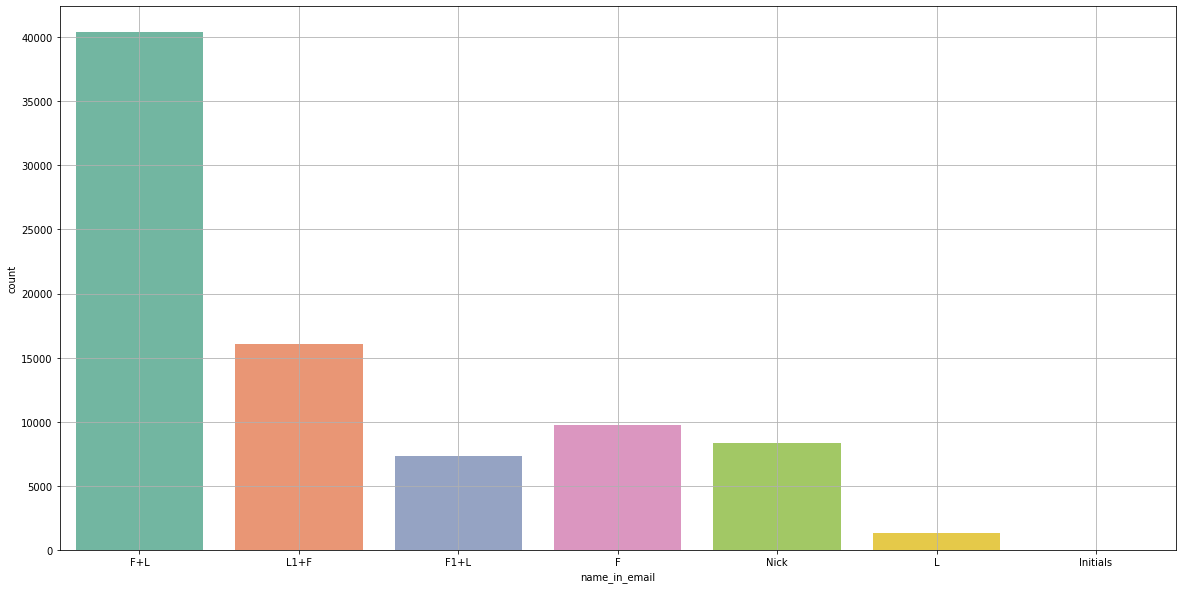

--------------------------
status_last_archived_0_24m
--------------------------

Unique values of 'status_last_archived_0_24m':
----------------------------------------------
1    71779
0    18739
2     7859
3     1597
5        2
Name: status_last_archived_0_24m, dtype: int64




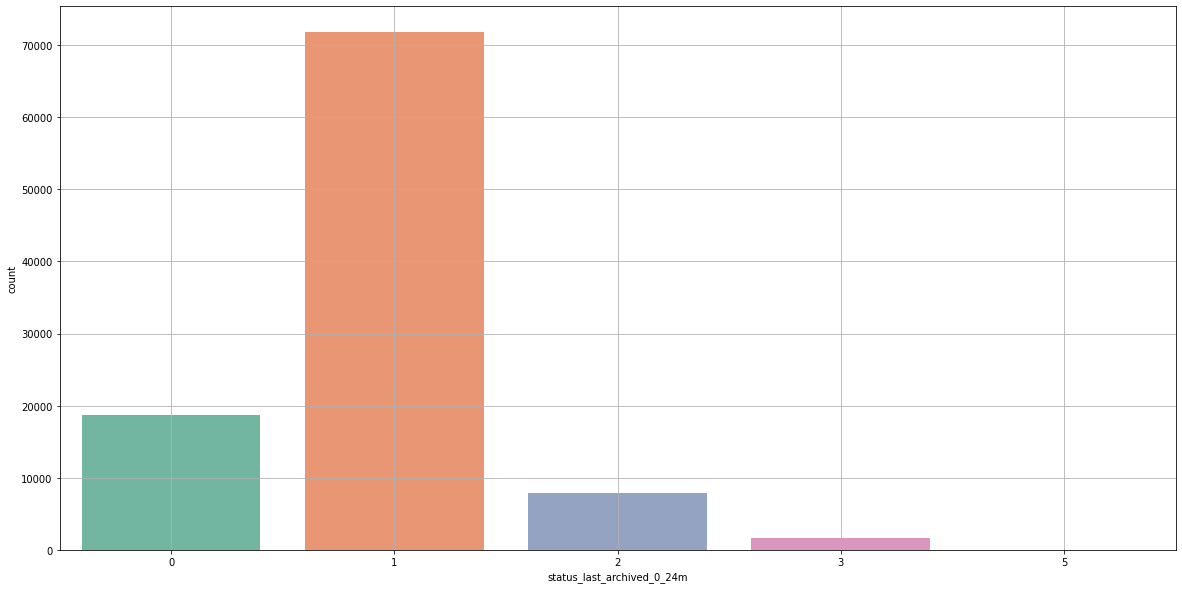

-------------------------------
status_max_archived_0_24_months
-------------------------------

Unique values of 'status_max_archived_0_24_months':
---------------------------------------------------
1    47064
2    27038
0    18739
3     7114
5       21
Name: status_max_archived_0_24_months, dtype: int64




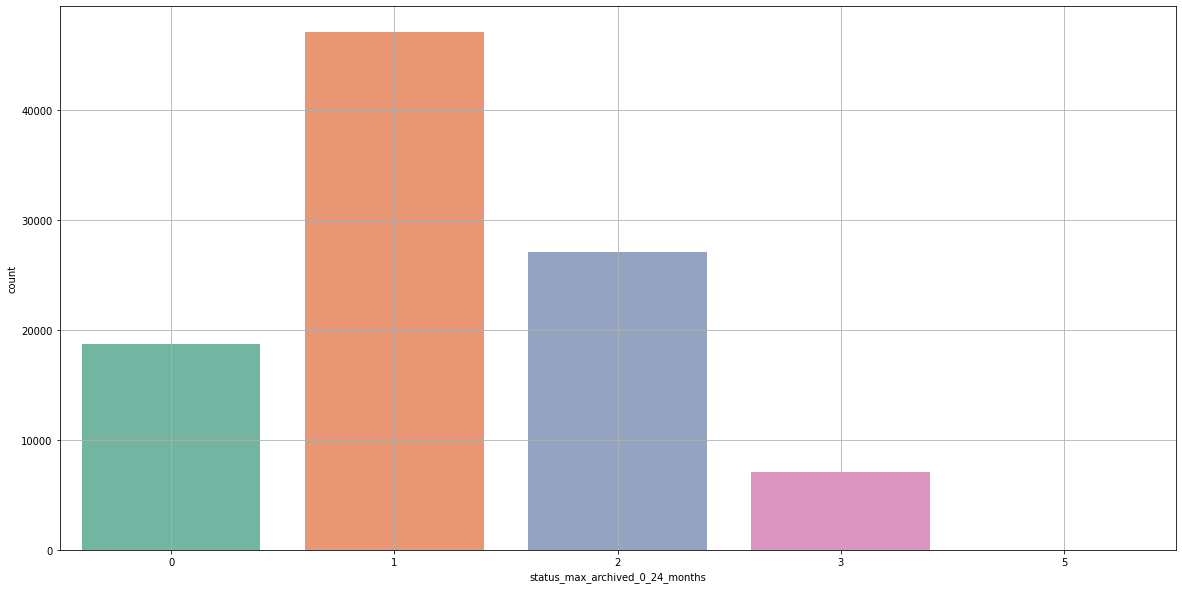

-------------------------------
status_max_archived_0_12_months
-------------------------------

Unique values of 'status_max_archived_0_12_months':
---------------------------------------------------
1    50943
0    24066
2    20666
3     4291
5       10
Name: status_max_archived_0_12_months, dtype: int64




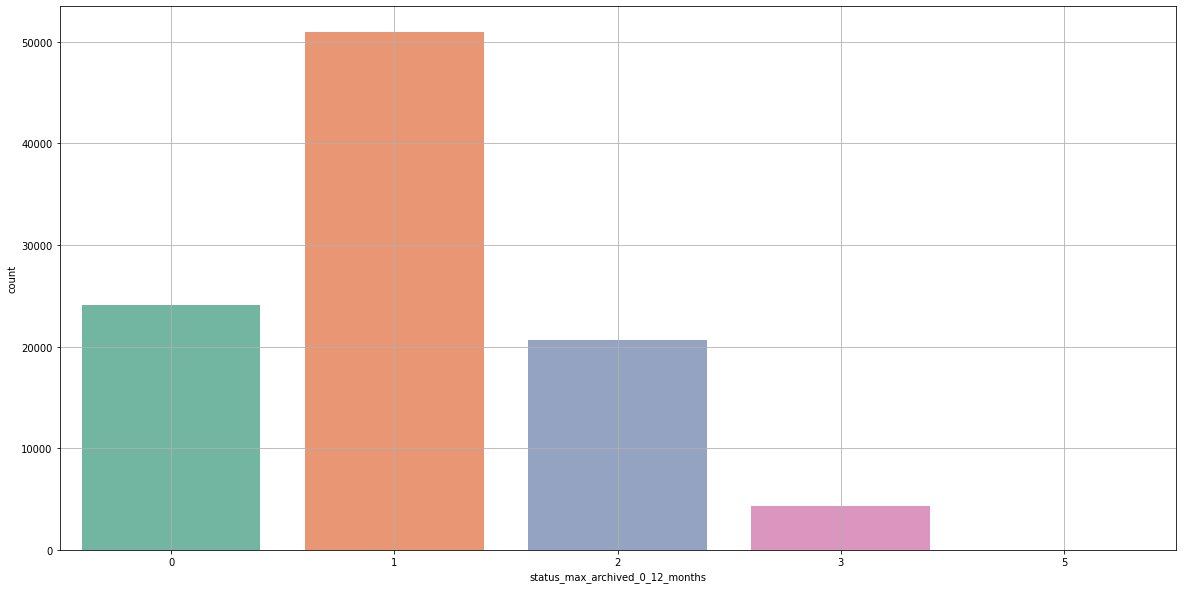

------------------------------
status_2nd_last_archived_0_24m
------------------------------

Unique values of 'status_2nd_last_archived_0_24m':
--------------------------------------------------
1    62740
0    27990
2     7752
3     1491
5        3
Name: status_2nd_last_archived_0_24m, dtype: int64




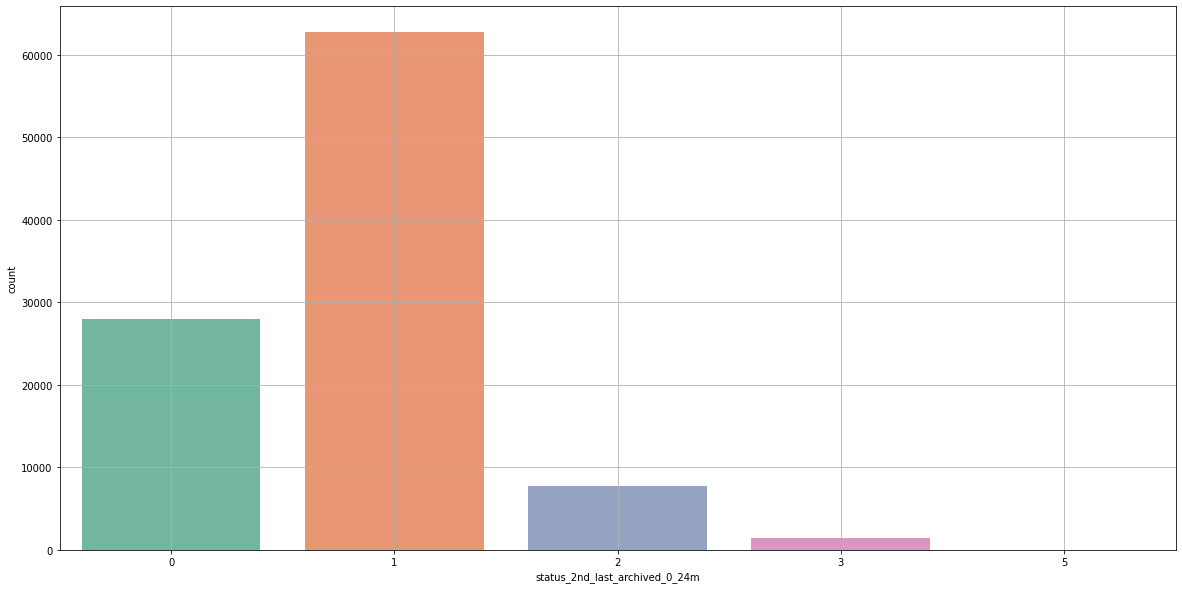

------------------------------
status_3rd_last_archived_0_24m
------------------------------

Unique values of 'status_3rd_last_archived_0_24m':
--------------------------------------------------
1    57008
0    34907
2     6787
3     1270
5        4
Name: status_3rd_last_archived_0_24m, dtype: int64




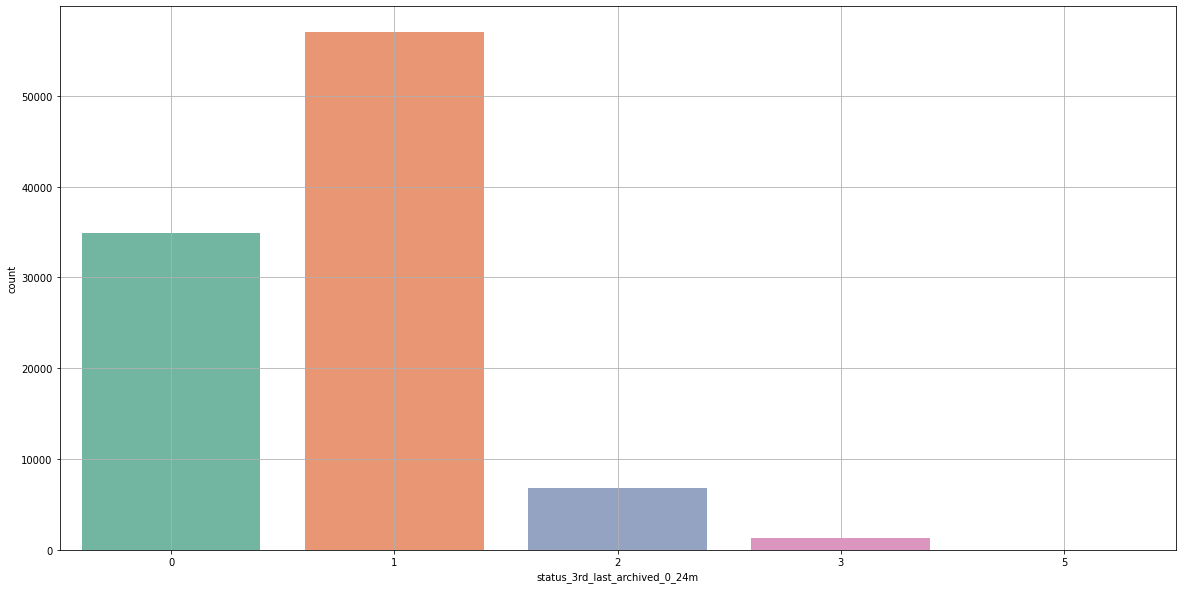

-------------------------
account_worst_status_0_3m
-------------------------

Unique values of 'account_worst_status_0_3m':
---------------------------------------------
1.0    38375
2.0     6678
3.0      443
4.0      107
Name: account_worst_status_0_3m, dtype: int64




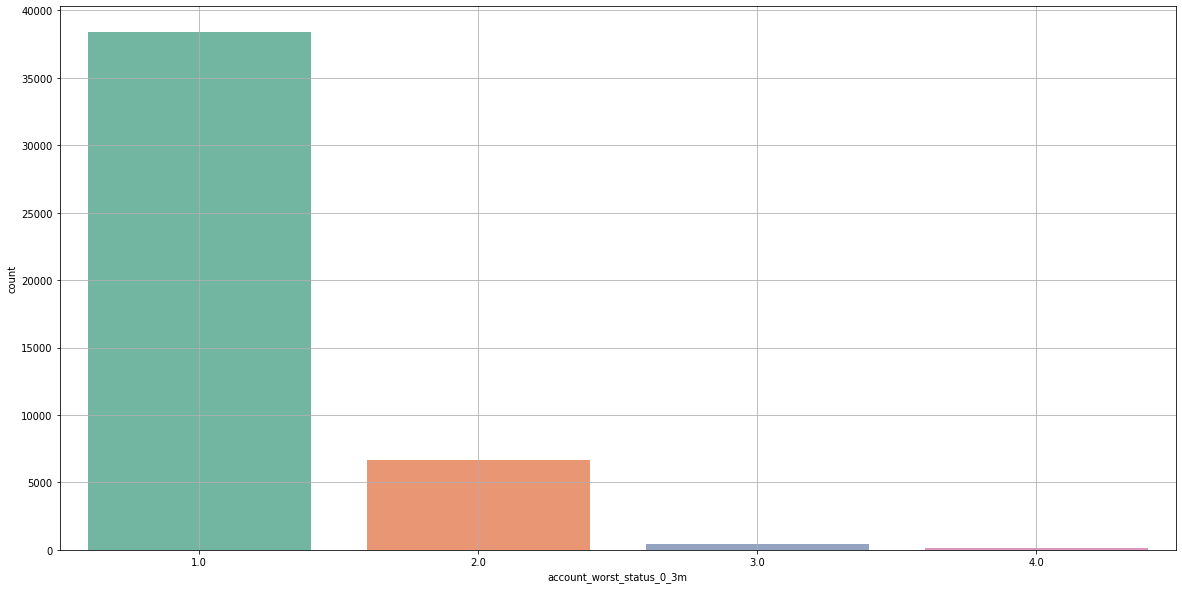

------------------------------
status_max_archived_0_6_months
------------------------------

Unique values of 'status_max_archived_0_6_months':
--------------------------------------------------
1    49416
0    36121
2    12694
3     1745
Name: status_max_archived_0_6_months, dtype: int64




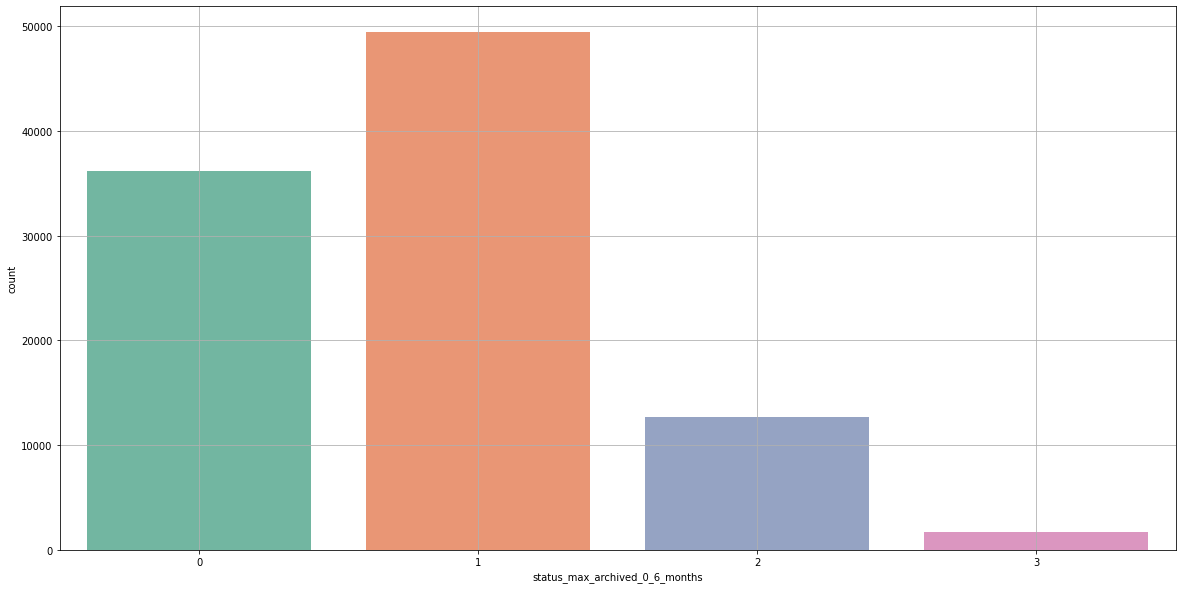

--------------------------
account_worst_status_6_12m
--------------------------

Unique values of 'account_worst_status_6_12m':
----------------------------------------------
1.0    30703
2.0     8025
3.0      688
4.0      210
Name: account_worst_status_6_12m, dtype: int64




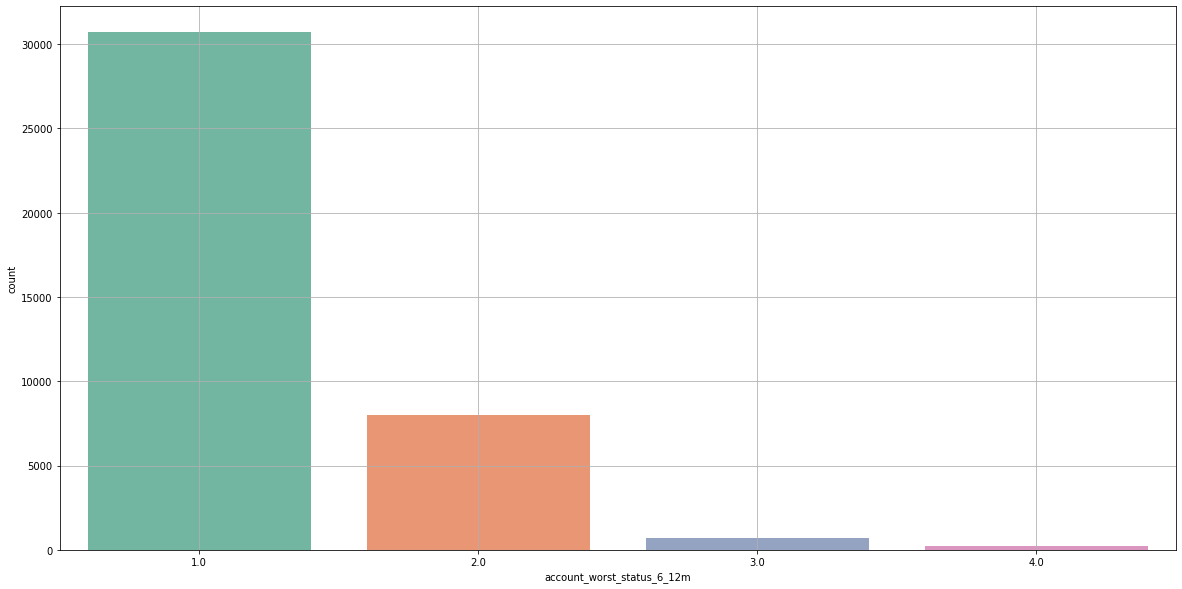

---------------------------
account_worst_status_12_24m
---------------------------

Unique values of 'account_worst_status_12_24m':
-----------------------------------------------
1.0    23527
2.0     8433
3.0      993
4.0      262
Name: account_worst_status_12_24m, dtype: int64




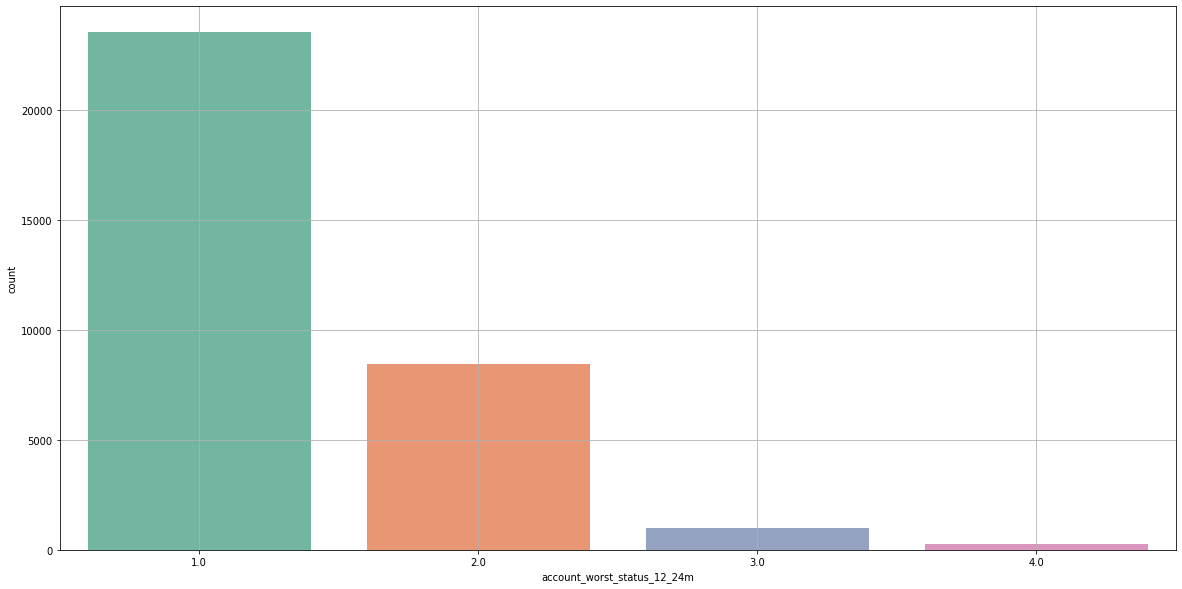

--------------
account_status
--------------

Unique values of 'account_status':
----------------------------------
1.0    43693
2.0     1900
3.0        7
4.0        3
Name: account_status, dtype: int64




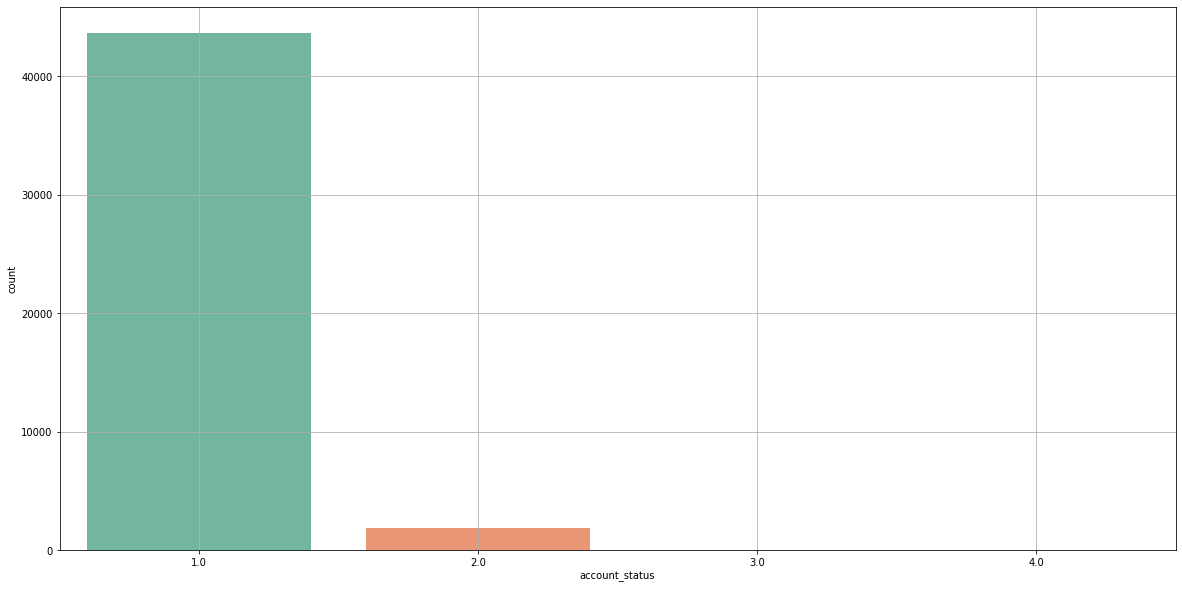

-------------------------
account_worst_status_3_6m
-------------------------

Unique values of 'account_worst_status_3_6m':
---------------------------------------------
1.0    35254
2.0     6357
3.0      513
4.0      150
Name: account_worst_status_3_6m, dtype: int64




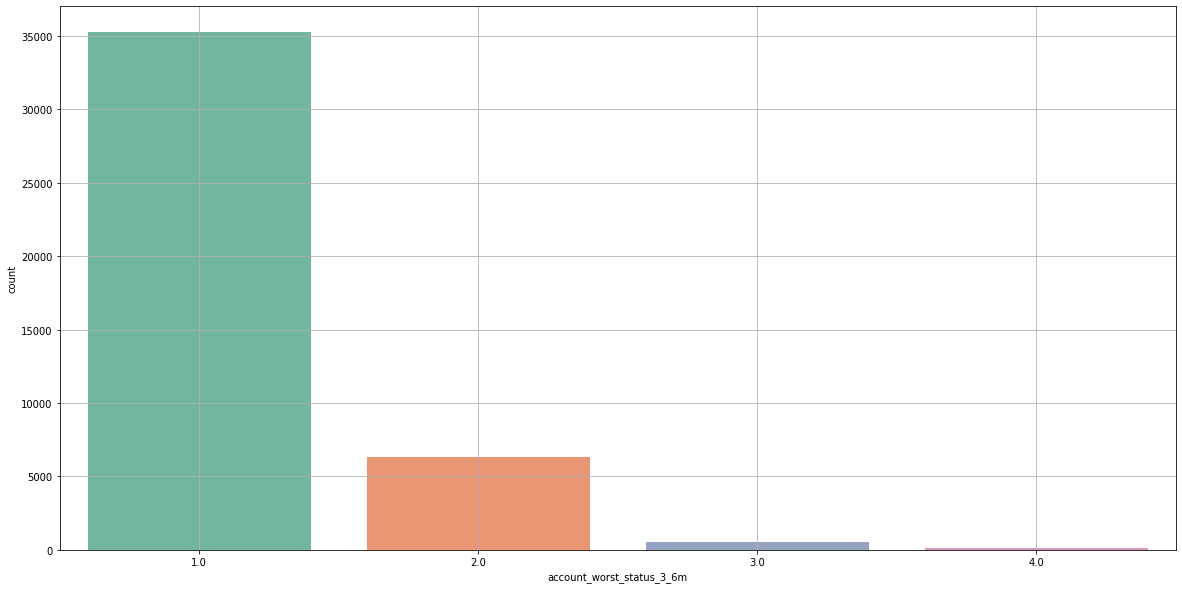

---------------------------
num_arch_written_off_12_24m
---------------------------

Unique values of 'num_arch_written_off_12_24m':
-----------------------------------------------
0.0    81887
1.0        9
2.0        2
Name: num_arch_written_off_12_24m, dtype: int64




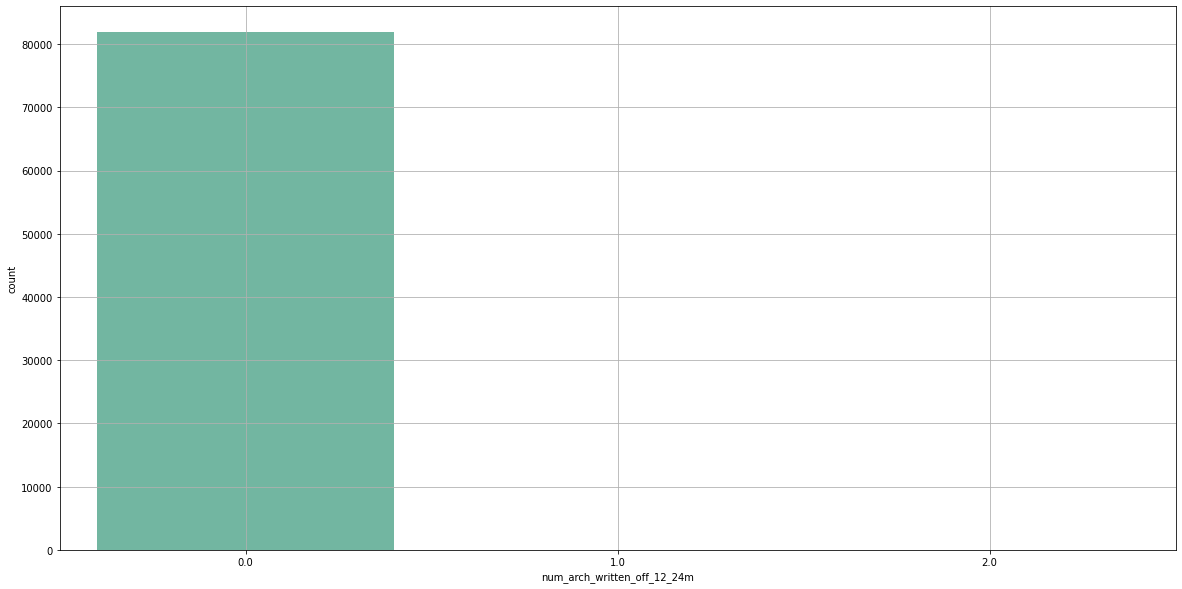

-----------------------
worst_status_active_inv
-----------------------

Unique values of 'worst_status_active_inv':
-------------------------------------------
1.0    26922
2.0     3369
3.0      170
Name: worst_status_active_inv, dtype: int64




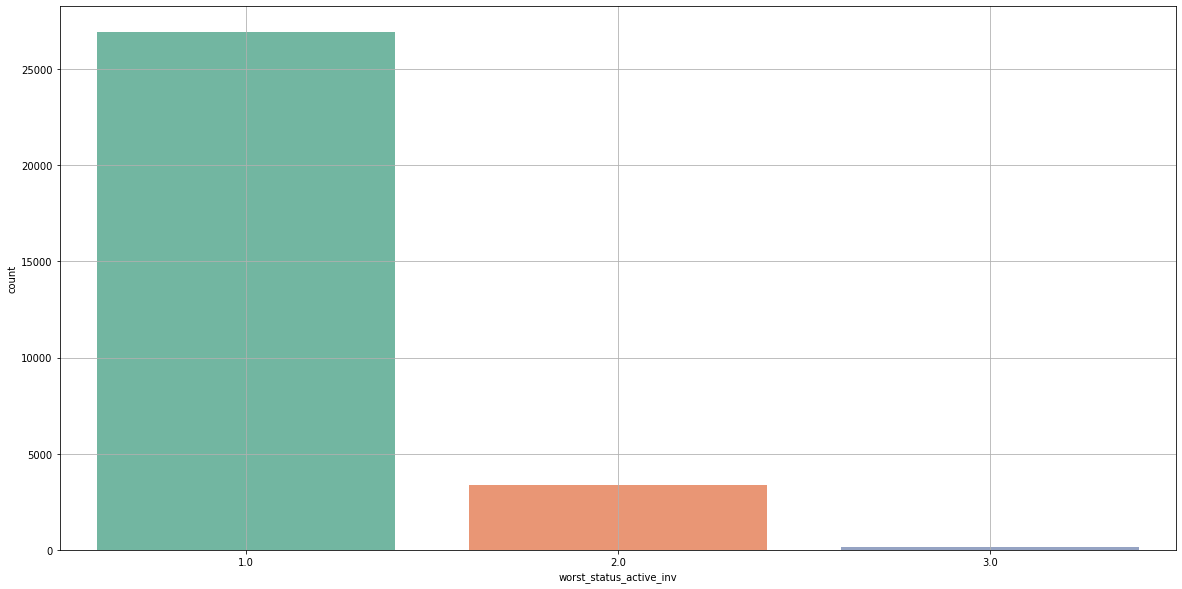

--------------------------
num_arch_written_off_0_12m
--------------------------

Unique values of 'num_arch_written_off_0_12m':
----------------------------------------------
0.0    81888
1.0       10
Name: num_arch_written_off_0_12m, dtype: int64




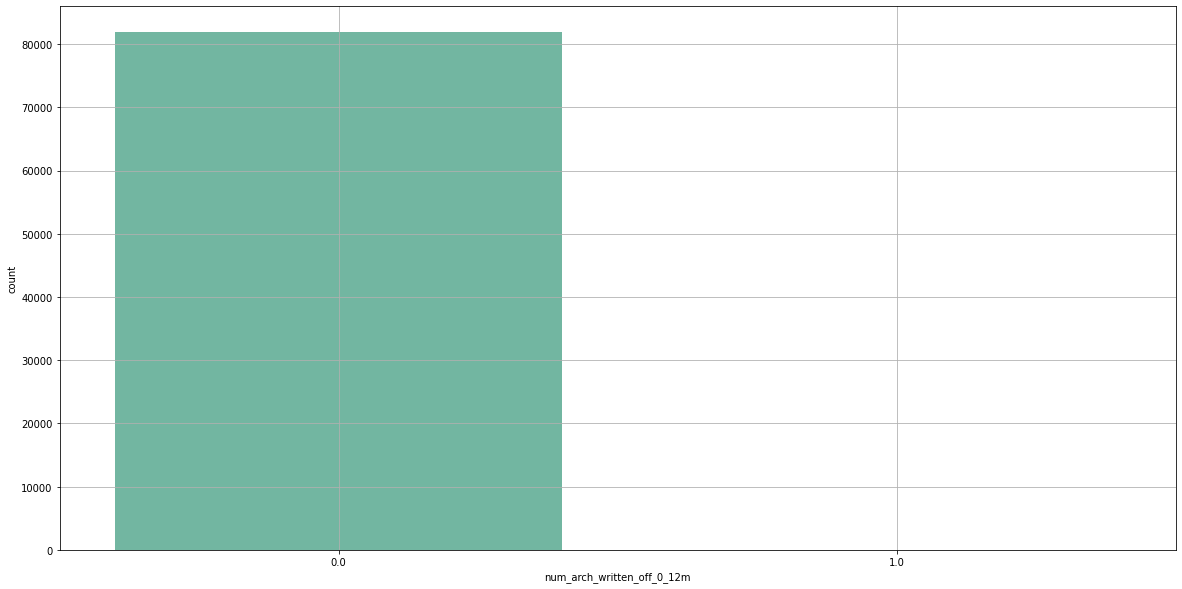

--------
has_paid
--------

Unique values of 'has_paid':
----------------------------
1    85096
0    14880
Name: has_paid, dtype: int64




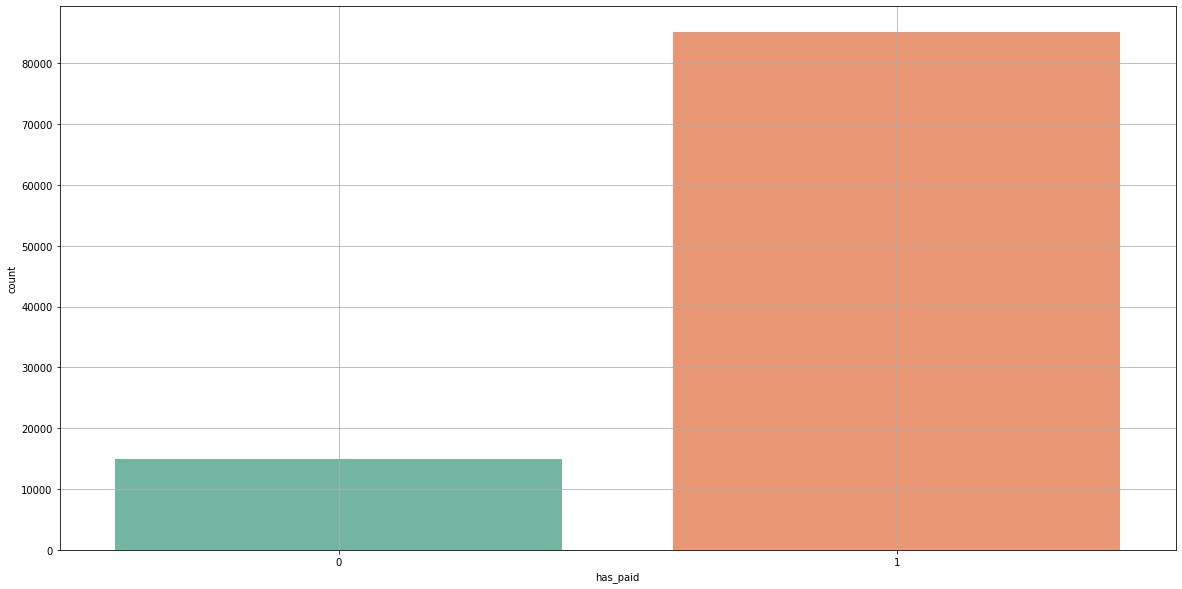

-------
default
-------

Unique values of 'default':
---------------------------
0.0    88688
1.0     1288
Name: default, dtype: int64




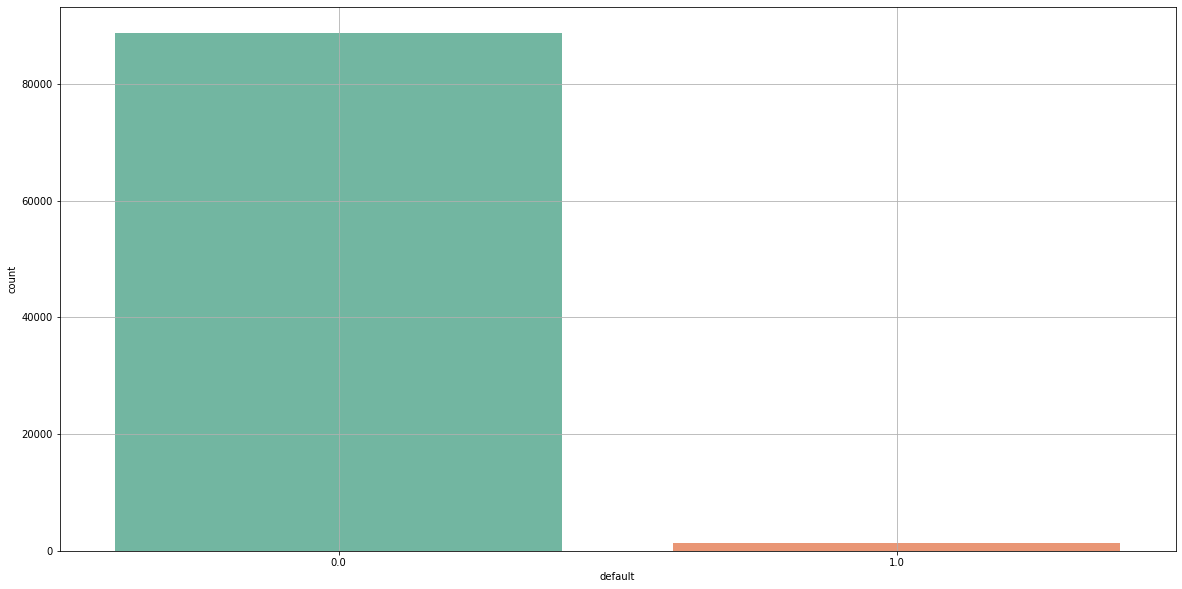

In [77]:

cols_for_bar_plot = df.nunique().sort_values(ascending=False)[23:].index.to_list()
for col in cols_for_bar_plot:
    print("-"*len(col))
    print(col)
    print("-"*len(col))
    print("")
    print(f"Unique values of '{col}':")
    print("-"*(20+len(col)))
    print(df[col].value_counts())
    print("\n")
    plt.figure(figsize=(20,10))
    sns.countplot(x=col, data=df, palette='Set2')
    plt.grid()
    plt.show()


df = df[df.columns.to_list()[2:]+[df.columns.to_list()[0]]+[df.columns.to_list()[1]]]

corr = df.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.5
top_corr_columns = cr.loc[:, 'default'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.1].sort_values(ascending=False)
len(best_accurate_columns)

In [78]:
before_fillna = best_accurate_columns
before_fillna

avg_payment_span_0_12m              0.142671
num_arch_dc_0_12m                   0.107296
num_arch_dc_12_24m                  0.100891
account_worst_status_0_3m           0.097868
num_active_div_by_paid_inv_0_12m    0.089507
account_days_in_term_12_24m         0.084198
account_days_in_rem_12_24m          0.083576
account_worst_status_3_6m           0.080939
account_worst_status_6_12m          0.080219
account_status                      0.069771
account_worst_status_12_24m         0.067244
account_days_in_dc_12_24m           0.063395
Name: default, dtype: float64

Missing value içeren sütunlar aşağıdaki gibidir: 
-------------------------------------------------


['default', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'account_worst_status_3_6m', 'account_worst_status_6_12m', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'name_in_email', 'num_active_div_by_paid_inv_0_12m', 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'worst_status_active_inv']




Missing value analizi için sütun ismi giriniz:  account_days_in_dc_12_24m



-------------------------
account_days_in_dc_12_24m:
-------------------------

0.0      87879
9.0         11
28.0        10
67.0         9
42.0         9
         ...  
158.0        1
45.0         1
48.0         1
150.0        1
316.0        1
Name: account_days_in_dc_12_24m, Length: 127, dtype: int64

-----------------------------------------------------
Descriptive Statistics for account_days_in_dc_12_24m:
-----------------------------------------------------

count    88140.000000
mean         0.223043
std          5.808117
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        365.000000
Name: account_days_in_dc_12_24m, dtype: float64


Percent of missing account_days_in_dc_12_24m records is 11.84%



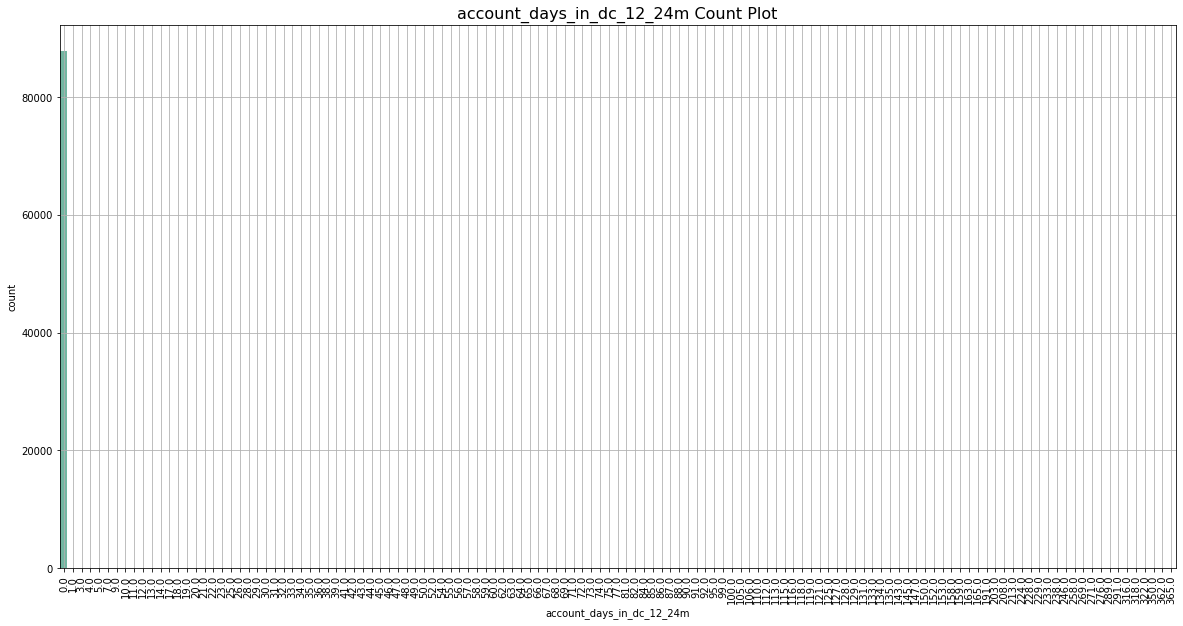

In [79]:

null_cols = list(df.isnull().sum()[df.isnull().sum() > 0].index)
print("Missing value içeren sütunlar aşağıdaki gibidir: ")
print("-"*len("Missing value içeren sütunlar aşağıdaki gibidir: "))
print("\n")
print(null_cols)
print("\n")
while True:
    try:
        col_to_plot = input("Missing value analizi için sütun ismi giriniz: ")
    except:
        pass
    if col_to_plot not in df.columns.to_list():
        continue
    else:
        break

for col in [col_to_plot]:
    print("")
    print("-"*(len(col)))
    print(f"{col}:")
    print("-"*(len(col)))
    print("")
    print(f"{df[col].value_counts().sort_values(ascending=False)}")
    print("")
    print("-"*(len(col)+len("Descriptive Statistics for  ")))
    print(f"Descriptive Statistics for {col}:")
    print("-"*(len(col)+len("Descriptive Statistics for  ")))
    print("")
    print(f"{df[col].describe()}")
    print("\n")
    print(f'Percent of missing {col} records is %.2f%%' %((df[col].isnull().sum()/df.shape[0])*100))
    print("="*180)
    print("")
    if col in ["account_incoming_debt_vs_paid_0_24m", "avg_payment_span_0_12m", "num_active_div_by_paid_inv_0_12m"]:
        plt.figure(figsize=(15,8))
        ax = df[col].hist(density=True, stacked=True, color='teal')
        df[col].plot(kind='density', color='teal')
        ax.set(xlabel=col)
        plt.grid()
        plt.show()
    else:
        plt.figure(figsize=(20,10))
        sns.countplot(x=col, data=df, palette='Set2')
        plt.title(col+" Count Plot", fontdict={"size": 16})
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()

In [80]:
df['account_worst_status_0_3m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_12_24m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_3_6m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df['account_worst_status_6_12m'].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df["account_status"].fillna(value=0, inplace=True) # Statüsü 1-2-3-4 olanlar. NA olanlara 0 atandı.
df["avg_payment_span_0_12m"].fillna(value=df["avg_payment_span_0_12m"].mean(), inplace=True) # Default ile korelasyonu 0 ile doldurduktan absolute 0.1'den yüksek çıkmıyor.
df["num_active_div_by_paid_inv_0_12m"].fillna(value=0, inplace=True) # Default ile korelasyonu 0 ile doldurduktan absolute 0.1'den yüksek çıkmıyor.
df["account_days_in_dc_12_24m"].fillna(value=0, inplace=True) #+
df["account_days_in_rem_12_24m"].fillna(value=0, inplace=True) #+
df["account_days_in_term_12_24m"].fillna(value=0, inplace=True) #+
df["name_in_email"].fillna(value=df["name_in_email"].value_counts().index[0], inplace=True) #+
df["num_arch_written_off_0_12m"].fillna(value=0, inplace=True) #+
df["num_arch_written_off_12_24m"].fillna(value=0, inplace=True) #+

In [81]:
cols_to_delete = ["avg_payment_span_0_3m", "max_paid_inv_0_24m", "num_arch_ok_12_24m",
                 "status_2nd_last_archived_0_24m", "status_3rd_last_archived_0_24m",
                  "status_max_archived_0_24_months", "status_max_archived_0_12_months",
                 "account_incoming_debt_vs_paid_0_24m", "worst_status_active_inv", 
                  "num_arch_written_off_0_12m", "num_arch_written_off_12_24m"]
df.drop(columns=cols_to_delete, axis=1, inplace=True)

In [82]:
sorted(df.columns.to_list())

['account_amount_added_12_24m',
 'account_days_in_dc_12_24m',
 'account_days_in_rem_12_24m',
 'account_days_in_term_12_24m',
 'account_status',
 'account_worst_status_0_3m',
 'account_worst_status_12_24m',
 'account_worst_status_3_6m',
 'account_worst_status_6_12m',
 'age',
 'avg_payment_span_0_12m',
 'default',
 'has_paid',
 'max_paid_inv_0_12m',
 'merchant_category',
 'merchant_group',
 'name_in_email',
 'num_active_div_by_paid_inv_0_12m',
 'num_active_inv',
 'num_arch_dc_0_12m',
 'num_arch_dc_12_24m',
 'num_arch_ok_0_12m',
 'num_arch_rem_0_12m',
 'num_unpaid_bills',
 'recovery_debt',
 'status_last_archived_0_24m',
 'status_max_archived_0_6_months',
 'sum_capital_paid_account_0_12m',
 'sum_capital_paid_account_12_24m',
 'sum_paid_inv_0_12m',
 'time_hours',
 'uuid']

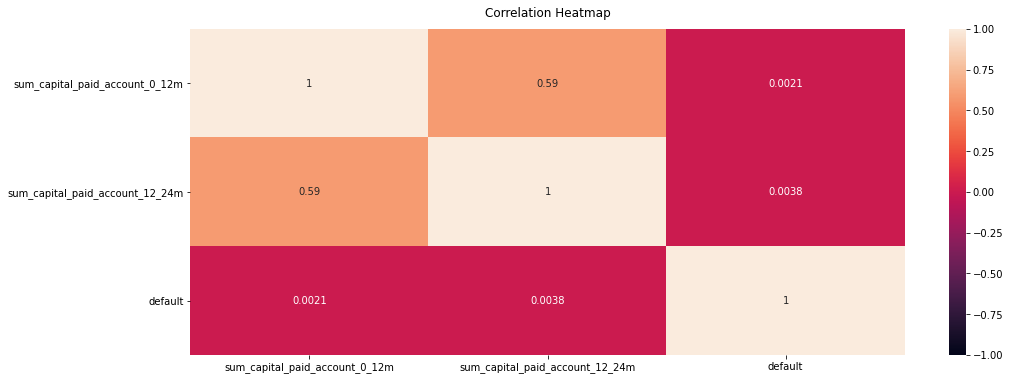

In [83]:

cols_to_check = [col for col in df.columns.to_list() if "sum_capital_paid_account_" in col]

dataframe = df[cols_to_check+["default"]]
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [84]:
corr = df.corr()
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.5
top_corr_columns = cr.loc[:, 'default'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.05].sort_values(ascending=False)
len(best_accurate_columns)

13

In [85]:
after_fillna = best_accurate_columns
after_fillna

default                             1.000000
avg_payment_span_0_12m              0.142671
num_arch_dc_0_12m                   0.107296
num_arch_dc_12_24m                  0.100891
account_worst_status_0_3m           0.097868
num_active_div_by_paid_inv_0_12m    0.089507
account_days_in_term_12_24m         0.084198
account_days_in_rem_12_24m          0.083576
account_worst_status_3_6m           0.080939
account_worst_status_6_12m          0.080219
account_status                      0.069771
account_worst_status_12_24m         0.067244
account_days_in_dc_12_24m           0.063395
Name: default, dtype: float64

---

---

---

# Calibrated - SVM - Random Forest

---

---

---

In [86]:
df_prepared = pd.read_csv("../data/prepared_data.csv")
df_prepared = reduce_mem_usage(df_prepared)

Mem. usage decreased to  3.05 Mb (71.4% reduction)


---

---

---

In [87]:
df_prepared = pd.merge(df_prepared, df[["uuid", "age", "merchant_category", "merchant_group", "name_in_email", "has_paid"]], how="left", on="uuid")

Method : auto    - Running Time : 0:00:00.011001 - Number of bins : 97    - Head : [18.         18.85416667 19.70833333] - Tail : [98.29166667 99.14583333]
Method : fd      - Running Time : 0:00:00.006001 - Number of bins : 97    - Head : [18.         18.85416667 19.70833333] - Tail : [98.29166667 99.14583333]
Method : doane   - Running Time : 0:00:00.011077 - Number of bins : 26    - Head : [18.   21.28 24.56] - Tail : [93.44 96.72]
Method : scott   - Running Time : 0:00:00.003002 - Number of bins : 85    - Head : [18.         18.97619048 19.95238095] - Tail : [98.04761905 99.02380952]
Method : stone   - Running Time : 0:00:01.002656 - Number of bins : 317   - Head : [18.         18.25949367 18.51898734] - Tail : [99.48101266 99.74050633]
Method : rice    - Running Time : 0:00:00.004967 - Number of bins : 94    - Head : [18.         18.88172043 19.76344086] - Tail : [98.23655914 99.11827957]
Method : sturges - Running Time : 0:00:00.003002 - Number of bins : 19    - Head : [18.       

,avg_payment_span_0_12m,num_arch_dc_0_12m,num_arch_dc_12_24m,account_worst_status_0_3m,num_active_div_by_paid_inv_0_12m,account_days_in_term_12_24m,account_days_in_rem_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,account_status,account_worst_status_12_24m,account_days_in_dc_12_24m,uuid,default,age,merchant_category,merchant_group,name_in_email,has_paid,age_category
0,12.695312,0,0,1.0,0.153809,0.0,0.0,1.0,0.0,1.0,0.0,0.0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,20,Dietary supplements,Health & Beauty,F+L,1,0
1,25.828125,0,0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,50,Books & Magazines,Entertainment,F+L,1,4
2,20.000000,0,0,0.0,0.071411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,22,Diversified entertainment,Entertainment,L1+F,1,0
3,4.687500,0,0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,36,Diversified entertainment,Entertainment,F1+L,1,2
4,13.000000,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,25,Electronic equipment & Related accessories,Electronics,F+L,1,0
99971,10.335938,0,0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,NaN,33,Electronic equipment & Related accessories,Electronics,F1+L,1,2
99972,36.000000,0,0,1.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.0,f8db22f4-9819-420c-abbc-9ddf1843176e,NaN,44,Body & Hair Care,Health & Beauty,F1+L,1,3
99973,17.968750,0,0,2.0,0.000000,0.0,20.0,1.0,1.0,2.0,2.0,0.0,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,24,Jewelry & Watches,Jewelry & Accessories,Nick,1,0
99974,17.500000,0,0,2.0,0.000000,0.0,0.0,2.0,2.0,1.0,1.0,0.0,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,31,Decoration & Art,Home & Garden,Nick,1,2
99975,34.656250,0,0,1.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,ac88f18c-96a6-49bc-9e9d-a780225914af,NaN,41,Dietary supplements,Health & Beauty,F1+L,1,3


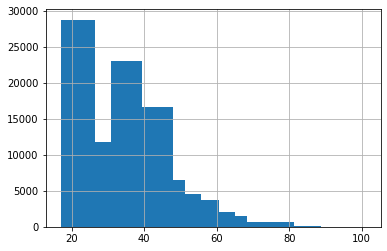

In [88]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins



# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)


age_bins = []
age_bins = get_columns_bins(df_prepared.age)


age_bin,label = get_clustering_bins(pd.Series(age_bins[0]), quantile=0.2, n_samples=10)
df_prepared.age.hist(bins=age_bin)
age_bin


len(age_bin) , df_prepared.age.value_counts(bins=age_bin)
df_prepared['age_category'] = pd.cut(df_prepared.age, age_bin).cat.codes
df_prepared.head(5).append(df_prepared.tail(5))

In [89]:
test = df_prepared.copy()

In [90]:
merchant_cat_others = list(df_prepared["merchant_category"].value_counts()[df_prepared["merchant_category"].value_counts() < 800].index)
df_prepared["merchant_category"] = df_prepared["merchant_category"].apply(lambda x: "Other" if x in merchant_cat_others else x)


merchant_dict = {'Entertainment':1, 'Leisure, Sport & Hobby':2, 'Clothing & Shoes':4, 'Health & Beauty':6, 'Jewelry & Accessories':7, 
                 'Food & Beverage':9, 'Children Products':11, 'Home & Garden':13, 'Electronics':15, 'Automotive Products':17, 
                 'Intangible products':19, 'Erotic Materials':20}

df_prepared["merchant_group"] = df_prepared["merchant_group"].replace(merchant_dict.keys(), merchant_dict.values())
df_prepared = pd.concat([df_prepared, pd.get_dummies(df_prepared["name_in_email"],prefix="in_email_")], axis=1)
df_prepared.drop(columns=["name_in_email", "age"], axis=1, inplace=True)


le_merchant_category = LabelEncoder()
df_prepared["merchant_category"] = le_merchant_category.fit_transform(df_prepared["merchant_category"])

#df_prepared = df_prepared[df_prepared.columns.to_list()[-16:] + df_prepared.columns.to_list()[:-16]]

---

---

---

# Balance the data using SMOTE

---

---

---

In [91]:
df_default_null = df_prepared[pd.isnull(df_prepared["default"])].reset_index(drop=True)

In [93]:
df_analyze = df_prepared.dropna().reset_index(drop=True)

X = df_analyze.drop(columns=["uuid", "default"])
y = df_analyze["default"]
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['default'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['default']==0]))
print("Number of subscription",len(os_data_y[os_data_y['default']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['default']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['default']==1])/len(os_data_X))

Length of oversampled data is  124204
Number of no subscription in oversampled data 62102
Number of subscription 62102
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


---

---

---

# Random Forest

---

---

---

In [95]:
os_data_X.shape, os_data_y.shape

((124204, 23), (124204, 1))

In [96]:
X_test.shape

(26993, 23)

In [97]:
start = time.time()

n_estimators = [200, 700]
max_depth = [5, 8]
min_samples_split = [10, 100]
min_samples_leaf = [5, 10]
hyper_random = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf}

clf_rf_tuned = GridSearchCV(RandomForestClassifier(), hyper_random, 
                            cv = 5, verbose = 1, 
                            n_jobs = 4)
clf_rf_tuned.fit(os_data_X, os_data_y)
best_params_random = clf_rf_tuned.best_params_
print(best_params_random)


CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])
CV_clf_rf.fit(os_data_X, os_data_y)
y_test_predict_proba_random = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_random = CV_clf_rf.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_random, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}

Çalışma süresi: 00:18:13.41


In [98]:
start = time.time()

# Create a corrected classifier.

clf_sigmoid = CalibratedClassifierCV(CV_clf_rf, cv=10, method='sigmoid')
clf_sigmoid.fit(os_data_X, os_data_y)
y_test_predict_proba_random_calibrated = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_calibrated_random = clf_sigmoid.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba_random_calibrated, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:08:17.56


---

---

## Random Forest Results

---

---

In [99]:
print(classification_report(y_test, yhat_random))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     26586
         1.0       0.07      0.51      0.12       407

    accuracy                           0.89     26993
   macro avg       0.53      0.70      0.53     26993
weighted avg       0.98      0.89      0.93     26993



---

---

## Calibrated Random Forest Results

---

---

In [100]:
print(classification_report(y_test, yhat_calibrated_random))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     26586
         1.0       0.07      0.51      0.12       407

    accuracy                           0.89     26993
   macro avg       0.53      0.71      0.53     26993
weighted avg       0.98      0.89      0.93     26993



---

---

# Gaussian Naive Bayes

---

---

In [101]:
start = time.time()
# Uncalibrated
clf_nb = GaussianNB()
clf_nb.fit(os_data_X, os_data_y)
y_test_predict_proba_nb = clf_nb.predict_proba(X_test)[:, 1]
yhat_nb = clf_nb.predict(X_test)
fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_proba_nb, n_bins=10)

#plt.plot(mean_predicted_value_nb, fraction_of_positives_nb, 's-', label='Uncalibrated')

# Calibrated
clf_sigmoid_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')
clf_sigmoid_nb.fit(os_data_X, os_data_y)
y_test_predict_proba_nb_calib = clf_sigmoid_nb.predict_proba(X_test)[:, 1]
yhat_calibrated_nb = clf_sigmoid_nb.predict(X_test)
fraction_of_positives_nb_calib, mean_predicted_value_nb_calib = calibration_curve(y_test, y_test_predict_proba_nb_calib, n_bins=10)

#plt.plot(mean_predicted_value_nb_calib, fraction_of_positives_nb_calib, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid_nb_calib_sig = CalibratedClassifierCV(clf_nb, cv=10, method='sigmoid')
clf_sigmoid_nb_calib_sig.fit(os_data_X, os_data_y)

y_test_predict_proba_nb_calib_platt = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_calibrated_platt = clf_sigmoid_nb_calib_sig.predict(X_test)

fraction_of_positives_nb_calib_platt, mean_predicted_value_nb_calib_platt = calibration_curve(y_test, y_test_predict_proba_nb_calib_platt, n_bins=10)
#plt.plot(mean_predicted_value_nb_calib_platt, fraction_of_positives_nb_calib_platt, 's-', color='orange', label='Calibrated (Platt)')


#plt.plot([0, 1], [0, 1], '--', color='gray')

#sns.despine(left=True, bottom=True)
#plt.gca().xaxis.set_ticks_position('none')
#plt.gca().yaxis.set_ticks_position('none')
#plt.gca().legend()
#plt.title("$GaussianNB$ Sample Calibration Curve", fontsize=20); pass

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:00:08.19


---

---

## Gaussian Naive Bayes Results

---

---

In [102]:
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     26586
         1.0       0.05      0.50      0.08       407

    accuracy                           0.84     26993
   macro avg       0.52      0.67      0.50     26993
weighted avg       0.98      0.84      0.90     26993



---

---

## Calibrated Gaussian Naive Bayes Results (Isotonic)

---

---

In [103]:
print(classification_report(y_test, yhat_calibrated_nb))

              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83     26586
         1.0       0.03      0.62      0.06       407

    accuracy                           0.71     26993
   macro avg       0.51      0.66      0.44     26993
weighted avg       0.98      0.71      0.81     26993



---

---

## Calibrated Gaussian Naive Bayes Results (Sigmoid)

---

---

In [104]:
print(classification_report(y_test, yhat_calibrated_platt))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     26586
         1.0       0.04      0.53      0.08       407

    accuracy                           0.82     26993
   macro avg       0.52      0.68      0.49     26993
weighted avg       0.98      0.82      0.89     26993



---

---

# NULL Results

In [105]:
df_default_null_keep = df_default_null[["uuid", "default"]]
df_default_null.drop(columns=["uuid", "default"], axis=1, inplace=True)

# Random Forest
y_predict_proba = CV_clf_rf.predict_proba(df_default_null)[:, 1]
yhat_predict = CV_clf_rf.predict(df_default_null)

# Calibrated Random Forest
y_predict_proba_crf = clf_sigmoid.predict_proba(df_default_null)[:, 1]
yhat_predict_crf = clf_sigmoid.predict(df_default_null)

#NB

y_predict_nb = clf_nb.predict_proba(df_default_null)[:, 1]
yhat_predict_nb = clf_nb.predict(df_default_null)

# Isotonic
y_predict_nb_isotonic = clf_sigmoid_nb.predict_proba(df_default_null)[:, 1]
yhat_predict_isotonic = clf_sigmoid_nb.predict(df_default_null)

# Sigmoid
y_predict_nb_sigmoid = clf_sigmoid_nb_calib_sig.predict_proba(df_default_null)[:, 1]
yhat_predict_sigmoid = clf_sigmoid_nb_calib_sig.predict(df_default_null)

In [106]:
nan_df_rf_nb = pd.concat([df_default_null_keep, 
           pd.Series(y_predict_proba, name="Random Forest Probability"),
           pd.Series(y_predict_proba_crf, name="Calibrated Random Forest Probability"),
           pd.Series(y_predict_nb, name="Naive Bayes"), 
           pd.Series(y_predict_nb_isotonic, name="Calibrated Naive Bayes (Isotonic)"),
           pd.Series(y_predict_nb_sigmoid, name="Calibrated Naive Bayes (Sigmoid)")], axis=1)

In [107]:
nan_df_rf_nb

,uuid,default,Random Forest Probability,Calibrated Random Forest Probability,Naive Bayes,Calibrated Naive Bayes (Isotonic),Calibrated Naive Bayes (Sigmoid)
0,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,NaN,0.214718,0.023897,5.084865e-17,0.063546,0.203981
1,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,NaN,0.248311,0.040090,1.562701e-10,0.063546,0.203981
2,e9c39869-1bc5-4375-b627-a2df70b445ea,NaN,0.249030,0.037699,1.942259e-10,0.063546,0.203981
3,6beb88a3-9641-4381-beb6-c9a208664dd0,NaN,0.123937,0.012089,7.200174e-01,0.714749,0.726636
4,bb89b735-72fe-42a4-ba06-d63be0f4ca36,NaN,0.515045,0.468593,1.343926e-19,0.063546,0.203981
...,...,...,...,...,...,...,...
9995,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,NaN,0.257225,0.058721,3.199405e-22,0.063546,0.203981
9996,f8db22f4-9819-420c-abbc-9ddf1843176e,NaN,0.240157,0.041732,2.772931e-22,0.063546,0.203981
9997,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,0.475112,0.364113,1.059708e-01,0.379241,0.266119
9998,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,0.468460,0.385877,1.371362e-01,0.382425,0.286430


# Train Results

In [108]:
df_default_train = df_analyze[df_analyze.index.isin(X_train.index.to_list())]

In [109]:
df_default_train.sort_index(inplace=True)
X_train.sort_index(inplace=True)

In [110]:
# Random Forest
y_predict_proba_train = CV_clf_rf.predict_proba(X_train)[:, 1]
yhat_predict_train = CV_clf_rf.predict(X_train)

# Calibrated Random Forest
y_predict_proba_crf_train = clf_sigmoid.predict_proba(X_train)[:, 1]
yhat_predict_crf_train = clf_sigmoid.predict(X_train)

#NB

y_predict_nb_train = clf_nb.predict_proba(X_train)[:, 1]
yhat_predict_nb_train = clf_nb.predict(X_train)

# Isotonic
y_predict_nb_isotonic_train = clf_sigmoid_nb.predict_proba(X_train)[:, 1]
yhat_predict_isotonic_train = clf_sigmoid_nb.predict(X_train)

# Sigmoid
y_predict_nb_sigmoid_train = clf_sigmoid_nb_calib_sig.predict_proba(X_train)[:, 1]
yhat_predict_sigmoid_train = clf_sigmoid_nb_calib_sig.predict(X_train)

In [111]:
train_df_rf_nb = pd.concat([df_default_train[["uuid", "default"]].reset_index(drop=True), 
           pd.Series(y_predict_proba_train, name="Random Forest Probability").reset_index(drop=True),
           pd.Series(y_predict_proba_crf_train, name="Calibrated Random Forest Probability").reset_index(drop=True),
           pd.Series(y_predict_nb_train, name="Naive Bayes").reset_index(drop=True), 
           pd.Series(y_predict_nb_isotonic_train, name="Calibrated Naive Bayes (Isotonic)").reset_index(drop=True),
           pd.Series(y_predict_nb_sigmoid_train, name="Calibrated Naive Bayes (Sigmoid)").reset_index(drop=True)], axis=1)

# Test Results

In [112]:

df_default_test = df_analyze[df_analyze.index.isin(X_test.index.to_list())]

In [113]:
df_default_test.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [114]:
# Random Forest
y_predict_proba_test = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_predict_test = CV_clf_rf.predict(X_test)

# Calibrated Random Forest
y_predict_proba_crf_test = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_predict_crf_test = clf_sigmoid.predict(X_test)

#NB

y_predict_nb_test = clf_nb.predict_proba(X_test)[:, 1]
yhat_predict_nb_test = clf_nb.predict(X_test)

# Isotonic
y_predict_nb_isotonic_test = clf_sigmoid_nb.predict_proba(X_test)[:, 1]
yhat_predict_isotonic_test = clf_sigmoid_nb.predict(X_test)

# Sigmoid
y_predict_nb_sigmoid_test = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_predict_sigmoid_test = clf_sigmoid_nb_calib_sig.predict(X_test)

In [115]:
test_df_rf_nb = pd.concat([df_default_test[["uuid", "default"]].reset_index(drop=True), 
                          pd.Series(y_predict_proba_test, name="Random Forest Probability").reset_index(drop=True),
                          pd.Series(y_predict_proba_crf_test, name="Calibrated Random Forest Probability").reset_index(drop=True),
                          pd.Series(y_predict_nb_test, name="Naive Bayes").reset_index(drop=True),
                          pd.Series(y_predict_nb_isotonic_test, name="Calibrated Naive Bayes (Isotonic)").reset_index(drop=True),
                          pd.Series(y_predict_nb_sigmoid_test, name="Calibrated Naive Bayes (Sigmoid)").reset_index(drop=True)], axis=1)

---

---

# Concat all results

---

---

In [116]:
df_all_results = pd.concat([nan_df_rf_nb, train_df_rf_nb, test_df_rf_nb], axis=0, ignore_index=True)

# SVM

---

---

In [117]:
"""
start = time.time()
#hyper_svm = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
#           "C": [1, 100, 1000],
#           "gamma": [1, 0.1, 0.00001]}


hyper_svm = {"kernel": ["rbf"],
           "C": [1],
           "gamma": [1]}
clf_svm_tuned = GridSearchCV(SVC(probability=True), 
                             hyper_svm,
                             cv=3,
                             verbose=1,
                             n_jobs=6)

clf_svm_tuned.fit(os_data_X, os_data_y)
best_params_svm = clf_svm_tuned.best_params_
print(best_params_svm)


CV_clf_svm = SVC(kernel=best_params_svm["kernel"],
                 C=best_params_svm["C"],
                 gamma=best_params_svm["gamma"],
                 probability=True)

CV_clf_svm.fit(os_data_X, os_data_y)
y_test_predict_proba_svm = CV_clf_svm.predict_proba(X_test)[:, 1]
yhat_svm = CV_clf_svm.predict(X_test)
fraction_of_positives_svm, mean_predicted_value_svm = calibration_curve(y_test, y_test_predict_proba_svm, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
"""

'\nstart = time.time()\n#hyper_svm = {"kernel": ["linear", "poly", "rbf", "sigmoid"],\n#           "C": [1, 100, 1000],\n#           "gamma": [1, 0.1, 0.00001]}\n\n\nhyper_svm = {"kernel": ["rbf"],\n           "C": [1],\n           "gamma": [1]}\nclf_svm_tuned = GridSearchCV(SVC(probability=True), \n                             hyper_svm,\n                             cv=3,\n                             verbose=1,\n                             n_jobs=6)\n\nclf_svm_tuned.fit(os_data_X, os_data_y)\nbest_params_svm = clf_svm_tuned.best_params_\nprint(best_params_svm)\n\n\nCV_clf_svm = SVC(kernel=best_params_svm["kernel"],\n                 C=best_params_svm["C"],\n                 gamma=best_params_svm["gamma"],\n                 probability=True)\n\nCV_clf_svm.fit(os_data_X, os_data_y)\ny_test_predict_proba_svm = CV_clf_svm.predict_proba(X_test)[:, 1]\nyhat_svm = CV_clf_svm.predict(X_test)\nfraction_of_positives_svm, mean_predicted_value_svm = calibration_curve(y_test, y_test_predict_pro

In [118]:
"""
start = time.time()
# Create a corrected classifier.
clf_sigmoid_svm = CalibratedClassifierCV(CV_clf_svm, cv=10, method='sigmoid')
clf_sigmoid_svm.fit(os_data_X, os_data_y)
y_test_predict_proba_svm_calibrated = clf_sigmoid_svm.predict_proba(X_test)[:, 1]
yhat_calibrated_svm = clf_sigmoid_svm.predict(X_test)
fraction_of_positives_svm_calibrated, mean_predicted_value_svm_calibrated = calibration_curve(y_test, y_test_predict_proba_svm_calibrated, n_bins=10)

#plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibrated (Platt)')
#plt.plot([0, 1], [0, 1], '--', color='gray')

#sns.despine(left=True, bottom=True)
#plt.gca().xaxis.set_ticks_position('none')
#plt.gca().yaxis.set_ticks_position('none')
#plt.gca().legend()
#plt.title("$SVM$ Sample Calibration Curve", fontsize=20); pass

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
"""

'\nstart = time.time()\n# Create a corrected classifier.\nclf_sigmoid_svm = CalibratedClassifierCV(CV_clf_svm, cv=10, method=\'sigmoid\')\nclf_sigmoid_svm.fit(os_data_X, os_data_y)\ny_test_predict_proba_svm_calibrated = clf_sigmoid_svm.predict_proba(X_test)[:, 1]\nyhat_calibrated_svm = clf_sigmoid_svm.predict(X_test)\nfraction_of_positives_svm_calibrated, mean_predicted_value_svm_calibrated = calibration_curve(y_test, y_test_predict_proba_svm_calibrated, n_bins=10)\n\n#plt.plot(mean_predicted_value, fraction_of_positives, \'s-\', label=\'Calibrated (Platt)\')\n#plt.plot([0, 1], [0, 1], \'--\', color=\'gray\')\n\n#sns.despine(left=True, bottom=True)\n#plt.gca().xaxis.set_ticks_position(\'none\')\n#plt.gca().yaxis.set_ticks_position(\'none\')\n#plt.gca().legend()\n#plt.title("$SVM$ Sample Calibration Curve", fontsize=20); pass\n\nend = time.time()\nhours, rem = divmod(end-start, 3600)\nminutes, seconds = divmod(rem, 60)\nprint("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hour

---

---

## SVM Results

---

---

In [119]:
"""
classification_report(y_test, yhat_svm)
"""

'\nclassification_report(y_test, yhat_svm)\n'

---

---

## Calibrated SVM Results

---

---

In [120]:
"""
classification_report(y_test, yhat_calibrated_svm)
"""

'\nclassification_report(y_test, yhat_calibrated_svm)\n'

In [121]:
df_all_results.to_csv("../data/Probability_All_Results.csv", index=False)

In [122]:
conn = sql.connect("df_all_results.db")
df_all_results.to_sql("../data/df_all_results", conn)

ValueError: Table '../data/df_all_results' already exists.